# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.3.1. Ajustes de parâmetros globais para os modelos
        - 4.3.2. Tunagem do modelo **Bayesian Ridge**
        - 4.3.3. Tunagem do modelo **Lasso**
        - 4.3.4. Tunagem do modelo **ElasticNet**
        - 4.3.5. Tunagem do modelo **Ridge**
    - 4.4. Salvando os modelos (.pkl)
    - 4.5. Análise gráfica de resíduos x previsões
5. **Conclusões**

<br>

---

<br>

## 1. Importação de bibliotecas

In [ ]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import os
import random

from sklearn.metrics import (make_scorer, mean_squared_error, mean_absolute_error, r2_score) 
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge)
from optuna.samplers import TPESampler

In [48]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [49]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 7913


In [50]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [51]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [52]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [53]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [54]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [55]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [56]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [57]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [58]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [59]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [60]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [61]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [62]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [63]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [64]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [65]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [66]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [67]:
# Definindo os modelos a serem testados

models =  { 
    'LinearRegression (BASELINE)': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
}


In [68]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, métricas para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [69]:
def zscore_norm(series):
    '''
    Normalização Z-score: (x - média) / desvio padrão

    :param series: pd.Series
        Série numérica a ser normalizada.

    :return: pd.Series or float
        Série normalizada usando Z-score.
        Retorna 0.0 caso desvio padrão seja zero (todos iguais).
    '''
    if series.std() == 0:
        return pd.Series(0.0, index=series.index)
    
    return (series - series.mean()) / series.std()


def add_final_score(df, w_mae=0.80, w_time=0.20):
    '''
    Adiciona colunas normalizadas e calcula um ranking Final_Score
    usando Z-score utilizando pesos proporcionais.

    :param df: pd.DataFrame
        DataFrame contendo as métricas dos modelos.
    :param w_mae: float, default=0.80
        Peso atribuído à métrica MAE na composição do score final.
    :param w_time: float, default=0.20
        Peso atribuído ao tempo de execução na composição do score final.   

    :return: pd.DataFrame
        DataFrame com colunas normalizadas e ranking Final_Score.
    '''

    # Normalização robusta
    df['MAE_norm'] = zscore_norm(df['Test_MAE'])
    df['Time_norm'] = zscore_norm(df['Time (s)'])

    # Score final (menor = melhor)
    df['Final_Score'] = (
        w_mae * df['MAE_norm'] +
        w_time * df['Time_norm']
    )

    # Ordenação para ranking
    df.sort_values('Final_Score', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [70]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_ranked = pd.DataFrame(results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_default = add_final_score(df_ranked)

print('\nResultado dos modelos SEM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,BayesianRidge,638.908211,588.939077,0.3272,-0.545506,-0.452278,-0.526860
1,Lasso,771.712695,783.743438,0.4029,-0.372820,-0.406933,-0.379642
2,Ridge,855.427365,879.050373,0.2836,-0.288334,-0.478395,-0.326346
3,LinearRegression (BASELINE),645.447939,561.578690,4.0676,-0.569760,1.788266,-0.098155
4,ElasticNet,3129.161097,3208.260115,0.3299,1.776419,-0.450660,1.331003


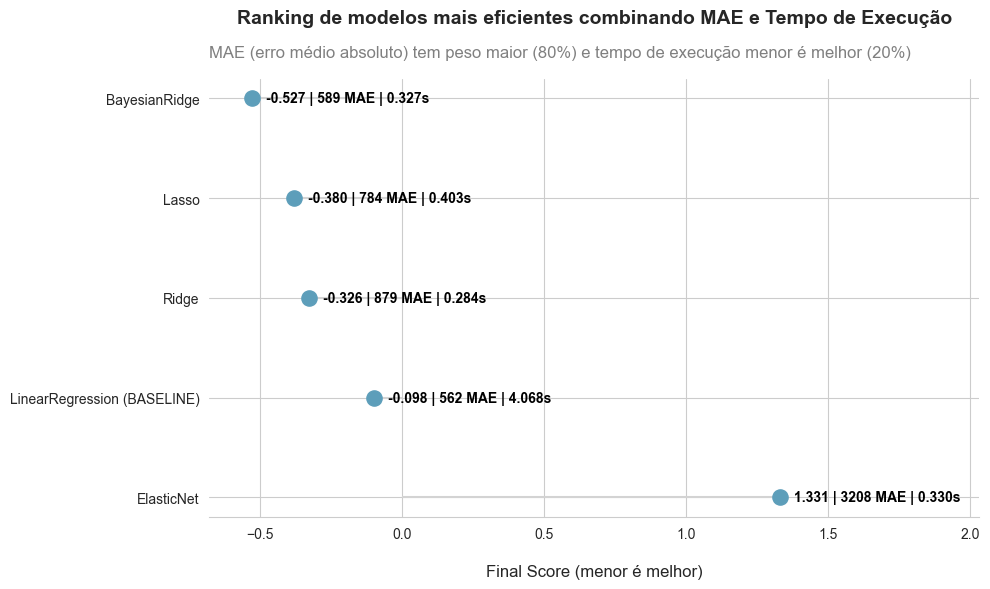

In [71]:
# Ordenar os modelos pelo Final_Score para o gráfico
df_plot = df_ranked_default.sort_values(by='Final_Score', ascending=False)

# Figura e eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Linha horizontal
ax.hlines(y=df_plot['Model'], xmin=df_plot['Final_Score'], xmax=0,
    color='lightgray', linewidth=1.5)

# Pontos no valor real
ax.scatter(df_plot['Final_Score'], df_plot['Model'], 
           color='#5d9eba', s=120, zorder=3)

# Adicionar texto com MAE e tempo
for score, mae, time_s, model in zip(
    df_plot['Final_Score'], df_plot['Test_MAE'], df_plot['Time (s)'], df_plot['Model']):
    ax.text(score + 0.05, model, f'{score:.3f} | {mae:.0f} MAE | {time_s:.3f}s',
        fontweight='bold', va='center', fontsize=10, color='#000000')

# Título e labels
ax.set_title('Ranking de modelos mais eficientes combinando MAE e Tempo de Execução',
             fontsize=14, fontweight='bold', pad=40)
ax.set_xlabel('\nFinal Score (menor é melhor)', fontsize=12)
ax.set_ylabel('')

# Subtítulo explicativo
ax.text(0, 1.05, 
        'MAE (erro médio absoluto) tem peso maior (80%) e tempo de execução menor é melhor (20%)',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)

# Ajuste de eixo para não cortar textos
ax.set_xlim(df_plot['Final_Score'].min() - 0.15,
            df_plot['Final_Score'].max() + 0.7)

# limpar borda superior e direita
sns.despine(left=True, bottom=False) 

# Ajuste final do layout para evitar sobreposição
plt.tight_layout()

# Exibição do gráfico
plt.show()


### 4.3. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.3.1. Ajustes de parâmetros globais para os modelos

In [72]:
def set_global_seed(seed=42):
    '''
    Define uma semente global para garantir reprodutibilidade em operações
    envolvendo geração de números aleatórios.

    :param seed: int, default=42
        Valor da semente que será aplicada globalmente.

    :return: None
        Não retorna valores. Apenas configura o ambiente.
    '''

    # Seed para NumPy
    np.random.seed(seed)

    # Seed para random (biblioteca padrão do Python)
    random.seed(seed)

    # Seed para hashing interno do Python
    os.environ['PYTHONHASHSEED'] = str(seed)


In [73]:
# Validação cruzada estável (50 folds = 5x10)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Usamos MAE negativo porque Optuna minimiza a função de objetivo
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

#### 4.3.2. Tunagem do modelo **Bayesian Ridge**

In [74]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 300, 1500),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-5, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-5, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-5, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-5, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [75]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 18:34:37,689] A new study created in memory with name: no-name-093e343b-6bf0-4705-9730-5cfb4e4e8b19
Best trial: 2. Best value: 638.908:   3%|▎         | 3/100 [00:01<00:33,  2.86it/s, 1.27/1800 seconds]

[I 2025-12-05 18:34:38,790] Trial 2 finished with value: 638.9082096621944 and parameters: {'max_iter': 595, 'tol': 1.5274856141108582e-05, 'alpha_1': 4.265326349487504e-06, 'alpha_2': 1.0004709235843238e-06, 'lambda_1': 2.645012042701387e-08, 'lambda_2': 1.2934640194504424e-06}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:38,793] Trial 0 finished with value: 638.9082100629558 and parameters: {'max_iter': 1461, 'tol': 1.4189718422573096e-06, 'alpha_1': 1.429324783989446e-08, 'alpha_2': 1.6799494593535408e-07, 'lambda_1': 4.557072423637271e-08, 'lambda_2': 6.9460819687261614e-06}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:38,965] Trial 3 finished with value: 638.9082174778436 and parameters: {'max_iter': 1250, 'tol': 1.3587319098278376e-05, 'alpha_1': 4.4034241303743795e-08, 'alpha_2': 2.312365743274268e-08, 'lambda_1': 8.11410636824347e-06, 'lambda_2': 1.256701630509417e-07}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:   4%|▍         | 4/100 [00:01<00:33,  2.86it/s, 1.33/1800 seconds]

[I 2025-12-05 18:34:39,021] Trial 4 finished with value: 638.9082100625891 and parameters: {'max_iter': 570, 'tol': 4.0161651462537475e-06, 'alpha_1': 5.376479488461265e-06, 'alpha_2': 9.086269414066347e-07, 'lambda_1': 5.717484131834359e-07, 'lambda_2': 4.360522343453245e-07}. Best is trial 2 with value: 638.9082096621944.


[I 2025-12-05 18:34:39,679] Trial 1 finished with value: 638.9082105602901 and parameters: {'max_iter': 551, 'tol': 9.50342700360139e-06, 'alpha_1': 2.8963361779703124e-07, 'alpha_2': 2.4084301142267504e-08, 'lambda_1': 6.132983490066004e-07, 'lambda_2': 7.623269283149179e-07}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:   6%|▌         | 6/100 [00:02<00:28,  3.25it/s, 2.17/1800 seconds]

[I 2025-12-05 18:34:39,793] Trial 5 finished with value: 638.9082098335022 and parameters: {'max_iter': 1429, 'tol': 3.3198879164884314e-06, 'alpha_1': 2.5816594067386565e-06, 'alpha_2': 7.669435953086579e-06, 'lambda_1': 4.8054647963254833e-08, 'lambda_2': 3.970715894034306e-08}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:  10%|█         | 10/100 [00:02<00:17,  5.00it/s, 2.88/1800 seconds]

[I 2025-12-05 18:34:40,416] Trial 7 finished with value: 638.9082107486383 and parameters: {'max_iter': 797, 'tol': 4.96202404652469e-06, 'alpha_1': 2.033611549495656e-08, 'alpha_2': 4.0144272821532236e-07, 'lambda_1': 7.918962757416794e-07, 'lambda_2': 1.6005580439607327e-08}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:40,420] Trial 6 finished with value: 638.9082101518018 and parameters: {'max_iter': 887, 'tol': 0.0003580616678538174, 'alpha_1': 1.066151320542586e-07, 'alpha_2': 2.108651530087193e-06, 'lambda_1': 1.3204835037653904e-07, 'lambda_2': 2.1159071863115708e-08}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:40,450] Trial 8 finished with value: 638.908212486964 and parameters: {'max_iter': 1442, 'tol': 0.0009175802749952889, 'alpha_1': 1.213379791946556e-07, 'alpha_2': 3.742934160776233e-08, 'lambda_1': 2.6461824884596655e-06, 'lambda_2': 2.810342794684654e-06}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:4

Best trial: 2. Best value: 638.908:  12%|█▏        | 12/100 [00:03<00:26,  3.35it/s, 3.65/1800 seconds]

[I 2025-12-05 18:34:41,235] Trial 10 finished with value: 638.9082099024675 and parameters: {'max_iter': 861, 'tol': 7.857934424684291e-06, 'alpha_1': 2.0821991871086064e-06, 'alpha_2': 3.11517354380849e-07, 'lambda_1': 7.38005722404191e-08, 'lambda_2': 4.790173469650697e-06}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:41,339] Trial 11 finished with value: 638.9082101735715 and parameters: {'max_iter': 741, 'tol': 2.4300092279863446e-06, 'alpha_1': 2.790939581185607e-07, 'alpha_2': 9.172283514605175e-07, 'lambda_1': 1.9185395492838205e-07, 'lambda_2': 1.5025438725159755e-06}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:41,407] Trial 12 finished with value: 638.9082125818793 and parameters: {'max_iter': 533, 'tol': 0.0007989982249116079, 'alpha_1': 2.31076647734986e-07, 'alpha_2': 3.5252961777942265e-07, 'lambda_1': 2.7669014610710413e-06, 'lambda_2': 5.765733649873401e-07}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:  16%|█▌        | 16/100 [00:04<00:24,  3.42it/s, 4.40/1800 seconds]

[I 2025-12-05 18:34:41,958] Trial 14 finished with value: 638.9082098735233 and parameters: {'max_iter': 673, 'tol': 0.00010923859051425071, 'alpha_1': 2.2176878565346798e-06, 'alpha_2': 7.253592213358809e-07, 'lambda_1': 5.0690310999476735e-08, 'lambda_2': 2.133069268174311e-08}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:41,969] Trial 13 finished with value: 638.9082114777514 and parameters: {'max_iter': 858, 'tol': 6.740395430771054e-06, 'alpha_1': 2.763272309797665e-07, 'alpha_2': 7.082073884046756e-06, 'lambda_1': 1.6101374264078426e-06, 'lambda_2': 3.9458412796887807e-07}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:42,091] Trial 15 finished with value: 638.908209943145 and parameters: {'max_iter': 1113, 'tol': 5.818241608432616e-05, 'alpha_1': 1.0177416155222825e-06, 'alpha_2': 7.886636792084658e-06, 'lambda_1': 1.0633737903788924e-08, 'lambda_2': 1.2616110920333652e-07}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:  18%|█▊        | 18/100 [00:05<00:20,  4.08it/s, 5.16/1800 seconds]

[I 2025-12-05 18:34:42,672] Trial 16 finished with value: 638.9082099421445 and parameters: {'max_iter': 1144, 'tol': 4.412906331029744e-05, 'alpha_1': 1.0500867867746045e-06, 'alpha_2': 7.702395465441686e-06, 'lambda_1': 1.3736511686091162e-08, 'lambda_2': 9.083447625978746e-08}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:42,850] Trial 18 finished with value: 638.9082099321005 and parameters: {'max_iter': 1099, 'tol': 4.0563592319396375e-05, 'alpha_1': 1.1242348681326562e-06, 'alpha_2': 8.139576510701321e-06, 'lambda_1': 1.031405287236387e-08, 'lambda_2': 7.038132674875111e-08}. Best is trial 2 with value: 638.9082096621944.


Best trial: 2. Best value: 638.908:  20%|██        | 20/100 [00:05<00:19,  4.08it/s, 5.25/1800 seconds]

[I 2025-12-05 18:34:42,917] Trial 17 finished with value: 638.9082099358347 and parameters: {'max_iter': 1205, 'tol': 6.244489896619593e-05, 'alpha_1': 1.11169725049943e-06, 'alpha_2': 9.17759702395979e-06, 'lambda_1': 1.1752240325691109e-08, 'lambda_2': 7.094993092204725e-08}. Best is trial 2 with value: 638.9082096621944.
[I 2025-12-05 18:34:42,930] Trial 19 finished with value: 638.9082099430392 and parameters: {'max_iter': 1098, 'tol': 3.6211091912396276e-05, 'alpha_1': 1.0517765365513338e-06, 'alpha_2': 7.289191988020371e-06, 'lambda_1': 1.5403668725478852e-08, 'lambda_2': 1.033357006287045e-07}. Best is trial 2 with value: 638.9082096621944.


Best trial: 20. Best value: 638.908:  22%|██▏       | 22/100 [00:05<00:16,  4.62it/s, 5.95/1800 seconds]

[I 2025-12-05 18:34:43,519] Trial 20 finished with value: 638.9082093057851 and parameters: {'max_iter': 1135, 'tol': 4.535883620731576e-05, 'alpha_1': 8.069143606164527e-06, 'alpha_2': 5.7645027453442365e-06, 'lambda_1': 1.0915274472037466e-08, 'lambda_2': 7.850613459589337e-08}. Best is trial 20 with value: 638.9082093057851.
[I 2025-12-05 18:34:43,642] Trial 21 finished with value: 638.9082099512419 and parameters: {'max_iter': 1158, 'tol': 2.4046636309961186e-05, 'alpha_1': 9.846398503101684e-07, 'alpha_2': 3.050342374461204e-06, 'lambda_1': 1.8184143637649415e-08, 'lambda_2': 6.847638168152367e-08}. Best is trial 20 with value: 638.9082093057851.


Best trial: 22. Best value: 638.908:  24%|██▍       | 24/100 [00:06<00:19,  3.97it/s, 6.65/1800 seconds]

[I 2025-12-05 18:34:44,201] Trial 22 finished with value: 638.9082091683497 and parameters: {'max_iter': 353, 'tol': 2.6786679554562162e-05, 'alpha_1': 9.674311229530245e-06, 'alpha_2': 2.721495039909228e-06, 'lambda_1': 1.9813330419015065e-08, 'lambda_2': 4.507867518691186e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:44,345] Trial 23 finished with value: 638.9082092549054 and parameters: {'max_iter': 303, 'tol': 1.8427395940570367e-05, 'alpha_1': 8.852872730791978e-06, 'alpha_2': 2.7196989442820653e-06, 'lambda_1': 3.3809258392657017e-08, 'lambda_2': 5.072763149950765e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  26%|██▌       | 26/100 [00:06<00:18,  3.97it/s, 6.74/1800 seconds]

[I 2025-12-05 18:34:44,381] Trial 25 finished with value: 638.9082091904862 and parameters: {'max_iter': 338, 'tol': 1.775836761845493e-05, 'alpha_1': 9.51312128138983e-06, 'alpha_2': 2.1850632468186725e-06, 'lambda_1': 2.8689934262449525e-08, 'lambda_2': 3.6697431485786924e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:44,426] Trial 24 finished with value: 638.9082092584686 and parameters: {'max_iter': 324, 'tol': 1.826858931026829e-05, 'alpha_1': 8.763298149007211e-06, 'alpha_2': 2.8214891686664516e-06, 'lambda_1': 2.8897712920965738e-08, 'lambda_2': 3.838795158367992e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  27%|██▋       | 27/100 [00:07<00:16,  4.46it/s, 7.24/1800 seconds]

[I 2025-12-05 18:34:44,925] Trial 26 finished with value: 638.9082091803338 and parameters: {'max_iter': 1296, 'tol': 1.8927890708426547e-05, 'alpha_1': 9.621108426336004e-06, 'alpha_2': 2.9081330642356114e-06, 'lambda_1': 2.8147701935622097e-08, 'lambda_2': 3.8066977624658623e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  28%|██▊       | 28/100 [00:07<00:16,  4.37it/s, 7.49/1800 seconds]

[I 2025-12-05 18:34:45,177] Trial 27 finished with value: 638.908209227881 and parameters: {'max_iter': 1385, 'tol': 1.8710460488204018e-05, 'alpha_1': 9.122923240005115e-06, 'alpha_2': 2.7464305630469113e-06, 'lambda_1': 3.092447090870093e-08, 'lambda_2': 3.783565089010229e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  30%|███       | 30/100 [00:07<00:18,  3.84it/s, 7.92/1800 seconds]

[I 2025-12-05 18:34:45,557] Trial 29 finished with value: 638.9082091885454 and parameters: {'max_iter': 320, 'tol': 0.00012736430719517217, 'alpha_1': 9.55859267010824e-06, 'alpha_2': 2.859386510601371e-06, 'lambda_1': 2.627295021783264e-08, 'lambda_2': 2.2636692135134133e-07}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:45,587] Trial 28 finished with value: 638.9082092831451 and parameters: {'max_iter': 324, 'tol': 1.4804986139077333e-05, 'alpha_1': 8.484652387011934e-06, 'alpha_2': 2.413184781930694e-06, 'lambda_1': 2.8534480031411903e-08, 'lambda_2': 2.2865187785947166e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  31%|███       | 31/100 [00:08<00:21,  3.23it/s, 8.65/1800 seconds]

[I 2025-12-05 18:34:46,338] Trial 30 finished with value: 638.9082092552061 and parameters: {'max_iter': 433, 'tol': 0.00011123241989173313, 'alpha_1': 9.392169458944548e-06, 'alpha_2': 2.0343986150801273e-06, 'lambda_1': 8.276365433513065e-08, 'lambda_2': 2.343027612970106e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  32%|███▏      | 32/100 [00:08<00:19,  3.45it/s, 8.87/1800 seconds]

[I 2025-12-05 18:34:46,555] Trial 31 finished with value: 638.9082096324505 and parameters: {'max_iter': 425, 'tol': 0.00011131244456283642, 'alpha_1': 5.359948487672304e-06, 'alpha_2': 1.7002968719907412e-06, 'lambda_1': 9.707564507150472e-08, 'lambda_2': 1.2255897191653661e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  34%|███▍      | 34/100 [00:09<00:19,  3.47it/s, 9.49/1800 seconds]

[I 2025-12-05 18:34:47,022] Trial 32 finished with value: 638.9082096700909 and parameters: {'max_iter': 423, 'tol': 0.0001308056794190172, 'alpha_1': 4.9208209967325335e-06, 'alpha_2': 1.7210370625078446e-06, 'lambda_1': 9.449747745532191e-08, 'lambda_2': 2.0888683511259013e-07}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:47,177] Trial 33 finished with value: 638.908209711745 and parameters: {'max_iter': 412, 'tol': 0.00011843665446321709, 'alpha_1': 4.5920235394389166e-06, 'alpha_2': 1.4199121211725334e-06, 'lambda_1': 1.0770895850418758e-07, 'lambda_2': 1.2608507929731711e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  35%|███▌      | 35/100 [00:09<00:19,  3.29it/s, 9.83/1800 seconds]

[I 2025-12-05 18:34:47,524] Trial 34 finished with value: 638.9082096875933 and parameters: {'max_iter': 429, 'tol': 0.00010953531156944693, 'alpha_1': 4.742598597429089e-06, 'alpha_2': 1.5325638375435476e-06, 'lambda_1': 9.643891746024238e-08, 'lambda_2': 2.561045622469329e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  36%|███▌      | 36/100 [00:10<00:18,  3.51it/s, 10.07/1800 seconds]

[I 2025-12-05 18:34:47,710] Trial 35 finished with value: 638.908209666556 and parameters: {'max_iter': 986, 'tol': 1.1177500374834843e-06, 'alpha_1': 4.529204714956891e-06, 'alpha_2': 1.5003393049279042e-06, 'lambda_1': 5.782805380360863e-08, 'lambda_2': 1.021630116141366e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  37%|███▋      | 37/100 [00:10<00:20,  3.01it/s, 10.52/1800 seconds]

[I 2025-12-05 18:34:48,211] Trial 36 finished with value: 638.9082096937041 and parameters: {'max_iter': 454, 'tol': 0.00010487014471959681, 'alpha_1': 4.514415841506793e-06, 'alpha_2': 1.368200991575314e-06, 'lambda_1': 8.09642984453727e-08, 'lambda_2': 1.036455940543645e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  38%|███▊      | 38/100 [00:10<00:19,  3.22it/s, 10.78/1800 seconds]

[I 2025-12-05 18:34:48,469] Trial 37 finished with value: 638.9082097178226 and parameters: {'max_iter': 459, 'tol': 1.275120380466434e-06, 'alpha_1': 3.932367534785501e-06, 'alpha_2': 4.392991070457031e-06, 'lambda_1': 5.4965729646486376e-08, 'lambda_2': 1.6262453673258564e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  39%|███▉      | 39/100 [00:11<00:19,  3.10it/s, 11.14/1800 seconds]

[I 2025-12-05 18:34:48,823] Trial 38 finished with value: 638.9082096556733 and parameters: {'max_iter': 995, 'tol': 1.1610952677286072e-06, 'alpha_1': 4.272531276501478e-06, 'alpha_2': 1.3080420234692142e-06, 'lambda_1': 2.0764951858162793e-08, 'lambda_2': 2.981771679556671e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  40%|████      | 40/100 [00:11<00:19,  3.02it/s, 11.49/1800 seconds]

[I 2025-12-05 18:34:49,179] Trial 39 finished with value: 638.9082097090358 and parameters: {'max_iter': 510, 'tol': 9.847271504440082e-06, 'alpha_1': 3.668668376711787e-06, 'alpha_2': 4.566273139330434e-06, 'lambda_1': 1.9067606717032725e-08, 'lambda_2': 2.6057253683079094e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  41%|████      | 41/100 [00:11<00:19,  3.06it/s, 11.80/1800 seconds]

[I 2025-12-05 18:34:49,493] Trial 40 finished with value: 638.9082097719393 and parameters: {'max_iter': 998, 'tol': 1.0490056593078154e-05, 'alpha_1': 3.22943117647107e-06, 'alpha_2': 4.509627044530735e-06, 'lambda_1': 4.431793857478926e-08, 'lambda_2': 2.5622661001652447e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  42%|████▏     | 42/100 [00:12<00:16,  3.48it/s, 12.00/1800 seconds]

[I 2025-12-05 18:34:49,678] Trial 41 finished with value: 638.9082099899977 and parameters: {'max_iter': 513, 'tol': 1.0947921629639803e-05, 'alpha_1': 5.763884791570189e-07, 'alpha_2': 4.4298076832827925e-06, 'lambda_1': 2.0901844421199687e-08, 'lambda_2': 1.5319052353163777e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  44%|████▍     | 44/100 [00:12<00:16,  3.42it/s, 12.67/1800 seconds]

[I 2025-12-05 18:34:50,246] Trial 42 finished with value: 638.9082097640461 and parameters: {'max_iter': 1306, 'tol': 1.0666005721449526e-05, 'alpha_1': 3.0409914732267787e-06, 'alpha_2': 5.121994491281044e-07, 'lambda_1': 1.7217594592754413e-08, 'lambda_2': 2.0482248675533482e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:50,358] Trial 43 finished with value: 638.9082099998482 and parameters: {'max_iter': 621, 'tol': 9.672353655475493e-06, 'alpha_1': 4.6825478796989563e-07, 'alpha_2': 4.8376779940697945e-06, 'lambda_1': 2.1147688615955475e-08, 'lambda_2': 2.1993020146375992e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  46%|████▌     | 46/100 [00:13<00:14,  3.76it/s, 13.19/1800 seconds]

[I 2025-12-05 18:34:50,716] Trial 44 finished with value: 638.9082099883541 and parameters: {'max_iter': 615, 'tol': 1.0887341839560433e-05, 'alpha_1': 5.999218483034361e-07, 'alpha_2': 4.4086941497856075e-06, 'lambda_1': 2.144251393937327e-08, 'lambda_2': 2.336801998382313e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:50,874] Trial 45 finished with value: 638.9082100103394 and parameters: {'max_iter': 1341, 'tol': 2.4878654870235982e-05, 'alpha_1': 5.481518002820297e-07, 'alpha_2': 5.656123860855993e-07, 'lambda_1': 3.959026635668314e-08, 'lambda_2': 8.086185011950517e-07}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  48%|████▊     | 48/100 [00:13<00:13,  3.87it/s, 13.72/1800 seconds]

[I 2025-12-05 18:34:51,244] Trial 46 finished with value: 638.9082094972888 and parameters: {'max_iter': 1341, 'tol': 2.9267477399008345e-05, 'alpha_1': 6.214048884517637e-06, 'alpha_2': 3.051655237047253e-06, 'lambda_1': 3.769782979357323e-08, 'lambda_2': 4.879558978332843e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:51,408] Trial 47 finished with value: 638.9082093756541 and parameters: {'max_iter': 1341, 'tol': 2.3391996094783862e-05, 'alpha_1': 7.514056565723266e-06, 'alpha_2': 5.58785183314552e-07, 'lambda_1': 3.33957828503141e-08, 'lambda_2': 4.3124524921076377e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  50%|█████     | 50/100 [00:14<00:15,  3.29it/s, 14.50/1800 seconds]

[I 2025-12-05 18:34:52,039] Trial 48 finished with value: 638.9082094796754 and parameters: {'max_iter': 1386, 'tol': 2.002545782767866e-05, 'alpha_1': 6.399624076445985e-06, 'alpha_2': 3.5316362517232832e-06, 'lambda_1': 3.737872782694498e-08, 'lambda_2': 4.261665964603544e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:52,092] Trial 49 finished with value: 638.9082094576793 and parameters: {'max_iter': 1396, 'tol': 2.654188691240802e-05, 'alpha_1': 6.6936236208205245e-06, 'alpha_2': 9.817508661530998e-08, 'lambda_1': 4.176675976109715e-08, 'lambda_2': 4.182587063247598e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  52%|█████▏    | 52/100 [00:14<00:13,  3.51it/s, 14.82/1800 seconds]

[I 2025-12-05 18:34:52,434] Trial 50 finished with value: 638.9082095996773 and parameters: {'max_iter': 1376, 'tol': 2.438986756334638e-05, 'alpha_1': 6.373463993471491e-06, 'alpha_2': 1.9548623408494243e-07, 'lambda_1': 1.6504268751811013e-07, 'lambda_2': 9.36993068931568e-07}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:52,486] Trial 51 finished with value: 638.9082094972865 and parameters: {'max_iter': 1309, 'tol': 2.9227986293742634e-05, 'alpha_1': 6.186220933097718e-06, 'alpha_2': 2.3034402687743037e-07, 'lambda_1': 3.4960313516931145e-08, 'lambda_2': 4.704502417818741e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  53%|█████▎    | 53/100 [00:15<00:11,  4.08it/s, 15.14/1800 seconds]

[I 2025-12-05 18:34:52,831] Trial 52 finished with value: 638.9082100800977 and parameters: {'max_iter': 1420, 'tol': 0.00043368395398068923, 'alpha_1': 1.8386123437698848e-06, 'alpha_2': 2.2051817496566853e-07, 'lambda_1': 2.1846294415355082e-07, 'lambda_2': 4.294236057088162e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  54%|█████▍    | 54/100 [00:15<00:13,  3.52it/s, 15.54/1800 seconds]

[I 2025-12-05 18:34:53,231] Trial 53 finished with value: 638.9082100277011 and parameters: {'max_iter': 1405, 'tol': 5.917664937181429e-06, 'alpha_1': 1.6163565344433292e-06, 'alpha_2': 2.0329675067621291e-07, 'lambda_1': 1.6433530460894447e-07, 'lambda_2': 3.412210244636317e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  56%|█████▌    | 56/100 [00:16<00:17,  2.58it/s, 16.27/1800 seconds]

[I 2025-12-05 18:34:53,913] Trial 54 finished with value: 638.9082101710756 and parameters: {'max_iter': 1474, 'tol': 6.09896459120935e-06, 'alpha_1': 1.7862966910613147e-06, 'alpha_2': 1.8824381119587621e-07, 'lambda_1': 3.3699340823163633e-07, 'lambda_2': 3.256782581450938e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:53,949] Trial 55 finished with value: 638.9082100547399 and parameters: {'max_iter': 1491, 'tol': 0.0004838627974548625, 'alpha_1': 1.9018226668200416e-06, 'alpha_2': 9.673131934153364e-07, 'lambda_1': 1.948961051886586e-07, 'lambda_2': 9.484746807898733e-06}. Best is trial 22 with value: 638.9082091683497.


Best trial: 22. Best value: 638.908:  59%|█████▉    | 59/100 [00:16<00:11,  3.65it/s, 16.80/1800 seconds]

[I 2025-12-05 18:34:54,316] Trial 57 finished with value: 638.9082099317742 and parameters: {'max_iter': 371, 'tol': 6.745460200804737e-05, 'alpha_1': 1.6801035771013667e-06, 'alpha_2': 2.2031324617233874e-06, 'lambda_1': 6.294041804390675e-08, 'lambda_2': 8.946800396251066e-06}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:54,474] Trial 56 finished with value: 638.9082170441682 and parameters: {'max_iter': 362, 'tol': 5.610733039285223e-06, 'alpha_1': 9.42862493348254e-06, 'alpha_2': 2.1792421021651904e-06, 'lambda_1': 8.564524980797459e-06, 'lambda_2': 5.7291912466320145e-08}. Best is trial 22 with value: 638.9082091683497.
[I 2025-12-05 18:34:54,495] Trial 58 finished with value: 638.9082100740467 and parameters: {'max_iter': 360, 'tol': 6.180122388809689e-06, 'alpha_1': 8.758754059908258e-08, 'alpha_2': 1.3058737299942938e-08, 'lambda_1': 6.456847790258252e-08, 'lambda_2': 1.6109701393061352e-08}. Best is trial 22 with value: 638.9082091683497.


Best trial: 59. Best value: 638.908:  60%|██████    | 60/100 [00:17<00:10,  3.90it/s, 17.25/1800 seconds]

[I 2025-12-05 18:34:54,929] Trial 59 finished with value: 638.9082091524467 and parameters: {'max_iter': 370, 'tol': 6.029090842670032e-05, 'alpha_1': 9.948685055386946e-06, 'alpha_2': 9.854293525874371e-07, 'lambda_1': 2.770095592577189e-08, 'lambda_2': 6.018424824529114e-08}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  62%|██████▏   | 62/100 [00:18<00:11,  3.24it/s, 18.11/1800 seconds]

[I 2025-12-05 18:34:55,652] Trial 60 finished with value: 638.9082092077895 and parameters: {'max_iter': 359, 'tol': 7.693984708642819e-05, 'alpha_1': 9.715161157697675e-06, 'alpha_2': 1.0707065618070138e-06, 'lambda_1': 6.423533353514185e-08, 'lambda_2': 1.0565399809959659e-07}. Best is trial 59 with value: 638.9082091524467.
[I 2025-12-05 18:34:55,803] Trial 61 finished with value: 638.9082100803417 and parameters: {'max_iter': 371, 'tol': 5.610719277810344e-05, 'alpha_1': 2.679269942468359e-08, 'alpha_2': 1.7089572522952886e-08, 'lambda_1': 6.256574019415123e-08, 'lambda_2': 5.824237480735928e-08}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  63%|██████▎   | 63/100 [00:18<00:10,  3.59it/s, 18.30/1800 seconds]

[I 2025-12-05 18:34:55,996] Trial 62 finished with value: 638.9082100404975 and parameters: {'max_iter': 301, 'tol': 1.6086720335446454e-05, 'alpha_1': 8.976114307616775e-08, 'alpha_2': 5.960007065263673e-06, 'lambda_1': 2.786514878499411e-08, 'lambda_2': 1.7391838232351943e-08}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  65%|██████▌   | 65/100 [00:18<00:07,  4.40it/s, 18.65/1800 seconds]

[I 2025-12-05 18:34:56,194] Trial 64 finished with value: 638.9082100340728 and parameters: {'max_iter': 319, 'tol': 1.5986245071809203e-05, 'alpha_1': 1.8501841219009677e-08, 'alpha_2': 6.1662254367528106e-06, 'lambda_1': 1.3854891617405651e-08, 'lambda_2': 9.583073821511727e-08}. Best is trial 59 with value: 638.9082091524467.
[I 2025-12-05 18:34:56,335] Trial 63 finished with value: 638.90821004487 and parameters: {'max_iter': 307, 'tol': 3.987286592491771e-06, 'alpha_1': 2.4039465749260176e-08, 'alpha_2': 5.894787001888771e-06, 'lambda_1': 2.673285328365256e-08, 'lambda_2': 1.6292743123805432e-08}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  66%|██████▌   | 66/100 [00:19<00:09,  3.55it/s, 19.07/1800 seconds]

[I 2025-12-05 18:34:56,754] Trial 65 finished with value: 638.9082100530056 and parameters: {'max_iter': 572, 'tol': 0.0002100993282961578, 'alpha_1': 1.9961562912250742e-08, 'alpha_2': 1.1084795880596389e-06, 'lambda_1': 2.528277404481435e-08, 'lambda_2': 1.0362968488104751e-07}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  67%|██████▋   | 67/100 [00:19<00:13,  2.52it/s, 19.75/1800 seconds]

[I 2025-12-05 18:34:57,444] Trial 66 finished with value: 638.9082100531068 and parameters: {'max_iter': 305, 'tol': 0.00016045687453253331, 'alpha_1': 1.2491690994816995e-08, 'alpha_2': 1.0930902310970153e-06, 'lambda_1': 2.6065992486344766e-08, 'lambda_2': 1.0705722752160921e-07}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  69%|██████▉   | 69/100 [00:20<00:09,  3.19it/s, 20.24/1800 seconds]

[I 2025-12-05 18:34:57,772] Trial 67 finished with value: 638.9082092028007 and parameters: {'max_iter': 487, 'tol': 0.00019781710405367318, 'alpha_1': 9.461339030090787e-06, 'alpha_2': 7.641889873767718e-07, 'lambda_1': 2.7744232497499115e-08, 'lambda_2': 9.465669992403248e-08}. Best is trial 59 with value: 638.9082091524467.
[I 2025-12-05 18:34:57,934] Trial 68 finished with value: 638.9082091591149 and parameters: {'max_iter': 1239, 'tol': 0.00016202082149453372, 'alpha_1': 9.796399114459197e-06, 'alpha_2': 7.123710906307199e-07, 'lambda_1': 1.4537092877485232e-08, 'lambda_2': 1.1013752364580361e-07}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  71%|███████   | 71/100 [00:20<00:06,  4.18it/s, 20.58/1800 seconds]

[I 2025-12-05 18:34:58,099] Trial 69 finished with value: 638.9082091527893 and parameters: {'max_iter': 487, 'tol': 0.0001729701034604075, 'alpha_1': 9.991915628201334e-06, 'alpha_2': 1.0939494361346067e-06, 'lambda_1': 2.566268404871147e-08, 'lambda_2': 3.70477110325898e-07}. Best is trial 59 with value: 638.9082091524467.
[I 2025-12-05 18:34:58,265] Trial 70 finished with value: 638.9082091688347 and parameters: {'max_iter': 489, 'tol': 0.00016722629143057385, 'alpha_1': 9.69493809306684e-06, 'alpha_2': 8.4545424748922e-07, 'lambda_1': 1.4180955785775007e-08, 'lambda_2': 3.7889684133831196e-07}. Best is trial 59 with value: 638.9082091524467.


Best trial: 59. Best value: 638.908:  72%|███████▏  | 72/100 [00:21<00:08,  3.37it/s, 21.01/1800 seconds]

[I 2025-12-05 18:34:58,682] Trial 71 finished with value: 638.9082091780613 and parameters: {'max_iter': 776, 'tol': 8.604495772573416e-05, 'alpha_1': 9.529116882111924e-06, 'alpha_2': 7.063097205367624e-07, 'lambda_1': 1.3385357686383195e-08, 'lambda_2': 3.761264483691009e-07}. Best is trial 59 with value: 638.9082091524467.


Best trial: 72. Best value: 638.908:  73%|███████▎  | 73/100 [00:21<00:12,  2.20it/s, 21.84/1800 seconds]

[I 2025-12-05 18:34:59,526] Trial 72 finished with value: 638.9082091422007 and parameters: {'max_iter': 492, 'tol': 6.761565629066219e-05, 'alpha_1': 9.93736387662594e-06, 'alpha_2': 8.351431708866506e-07, 'lambda_1': 1.5050656081174635e-08, 'lambda_2': 3.950736209220404e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  75%|███████▌  | 75/100 [00:22<00:07,  3.19it/s, 22.22/1800 seconds]

[I 2025-12-05 18:34:59,808] Trial 73 finished with value: 638.9082091798466 and parameters: {'max_iter': 480, 'tol': 8.750612292514779e-05, 'alpha_1': 9.526965192048588e-06, 'alpha_2': 8.41155500809453e-07, 'lambda_1': 1.510860082922068e-08, 'lambda_2': 3.7902824225000495e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:34:59,914] Trial 74 finished with value: 638.9082098166432 and parameters: {'max_iter': 1203, 'tol': 0.00029188930281451677, 'alpha_1': 2.5509873550052683e-06, 'alpha_2': 7.060401343778466e-07, 'lambda_1': 1.3479542190227796e-08, 'lambda_2': 3.576957455113587e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  76%|███████▌  | 76/100 [00:22<00:06,  3.44it/s, 22.46/1800 seconds]

[I 2025-12-05 18:35:00,149] Trial 75 finished with value: 638.9082098293288 and parameters: {'max_iter': 772, 'tol': 0.00026911192409386864, 'alpha_1': 2.38572439230645e-06, 'alpha_2': 7.823169488696813e-07, 'lambda_1': 1.292517084518063e-08, 'lambda_2': 5.261051152083895e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  77%|███████▋  | 77/100 [00:22<00:06,  3.47it/s, 22.74/1800 seconds]

[I 2025-12-05 18:35:00,424] Trial 76 finished with value: 638.9082093939904 and parameters: {'max_iter': 1224, 'tol': 0.0002903607260919486, 'alpha_1': 7.225181471391777e-06, 'alpha_2': 7.455058745066328e-07, 'lambda_1': 1.2816606022746842e-08, 'lambda_2': 3.7788793437053417e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  78%|███████▊  | 78/100 [00:23<00:06,  3.39it/s, 23.05/1800 seconds]

[I 2025-12-05 18:35:00,741] Trial 77 finished with value: 638.9082093536653 and parameters: {'max_iter': 788, 'tol': 0.00031848847624498227, 'alpha_1': 7.702399968082953e-06, 'alpha_2': 7.501378273339594e-07, 'lambda_1': 1.2500565368495712e-08, 'lambda_2': 4.432513363417019e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  80%|████████  | 80/100 [00:23<00:06,  3.05it/s, 23.86/1800 seconds]

[I 2025-12-05 18:35:01,397] Trial 78 finished with value: 638.9082093791855 and parameters: {'max_iter': 762, 'tol': 8.602015163091273e-05, 'alpha_1': 7.296184258052949e-06, 'alpha_2': 7.54847410331116e-07, 'lambda_1': 1.2849335665344334e-08, 'lambda_2': 4.2088897584815214e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:01,511] Trial 79 finished with value: 638.9082093761144 and parameters: {'max_iter': 721, 'tol': 0.00030904964708412173, 'alpha_1': 7.431524633645264e-06, 'alpha_2': 3.920936817602151e-07, 'lambda_1': 1.365624797924764e-08, 'lambda_2': 3.8133939872718306e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  82%|████████▏ | 82/100 [00:24<00:04,  4.16it/s, 24.18/1800 seconds]

[I 2025-12-05 18:35:01,740] Trial 80 finished with value: 638.9082093744036 and parameters: {'max_iter': 750, 'tol': 8.365904053632548e-05, 'alpha_1': 7.345195980454472e-06, 'alpha_2': 4.0997902173269575e-07, 'lambda_1': 1.2459103945558093e-08, 'lambda_2': 4.765946370016234e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:01,871] Trial 81 finished with value: 638.9082093676437 and parameters: {'max_iter': 677, 'tol': 8.659793715549326e-05, 'alpha_1': 7.454962396860003e-06, 'alpha_2': 3.7430939624475086e-07, 'lambda_1': 1.5937201412552377e-08, 'lambda_2': 4.7349351986445434e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  83%|████████▎ | 83/100 [00:24<00:05,  3.27it/s, 24.64/1800 seconds]

[I 2025-12-05 18:35:02,326] Trial 82 finished with value: 638.9082095248251 and parameters: {'max_iter': 699, 'tol': 0.00016052695101516408, 'alpha_1': 5.704318363151277e-06, 'alpha_2': 4.338754068898022e-07, 'lambda_1': 1.0429460601166152e-08, 'lambda_2': 4.91856669515159e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  84%|████████▍ | 84/100 [00:25<00:05,  3.05it/s, 25.02/1800 seconds]

[I 2025-12-05 18:35:02,704] Trial 83 finished with value: 638.9082095098928 and parameters: {'max_iter': 680, 'tol': 8.387752950651728e-05, 'alpha_1': 5.889104620865771e-06, 'alpha_2': 4.0805983506178973e-07, 'lambda_1': 1.6820759686204576e-08, 'lambda_2': 2.8901505393265334e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  86%|████████▌ | 86/100 [00:25<00:06,  2.16it/s, 25.89/1800 seconds]

[I 2025-12-05 18:35:03,491] Trial 84 finished with value: 638.9082095526182 and parameters: {'max_iter': 829, 'tol': 5.0046088745241314e-05, 'alpha_1': 5.330643202533237e-06, 'alpha_2': 4.3148362511172123e-07, 'lambda_1': 1.0073714669991697e-08, 'lambda_2': 2.762297970512102e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:03,574] Trial 85 finished with value: 638.9082095556514 and parameters: {'max_iter': 556, 'tol': 0.0001587645374042552, 'alpha_1': 5.425357350337876e-06, 'alpha_2': 4.923269579740541e-07, 'lambda_1': 1.658072956718738e-08, 'lambda_2': 3.0130082336858946e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  87%|████████▋ | 87/100 [00:26<00:04,  3.20it/s, 26.07/1800 seconds]

[I 2025-12-05 18:35:03,763] Trial 86 finished with value: 638.9082095518678 and parameters: {'max_iter': 552, 'tol': 0.00014956098134564857, 'alpha_1': 5.47204853682609e-06, 'alpha_2': 2.9537763906195326e-07, 'lambda_1': 1.7617323725949563e-08, 'lambda_2': 2.825687949874535e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  88%|████████▊ | 88/100 [00:26<00:03,  3.45it/s, 26.29/1800 seconds]

[I 2025-12-05 18:35:03,983] Trial 87 finished with value: 638.9082147478488 and parameters: {'max_iter': 546, 'tol': 5.0743870685428526e-05, 'alpha_1': 5.183304104366965e-06, 'alpha_2': 4.81450804273721e-07, 'lambda_1': 5.647597964588207e-06, 'lambda_2': 6.004443039219739e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  89%|████████▉ | 89/100 [00:26<00:03,  3.37it/s, 26.60/1800 seconds]

[I 2025-12-05 18:35:04,289] Trial 88 finished with value: 638.908209576366 and parameters: {'max_iter': 565, 'tol': 5.331841211810194e-05, 'alpha_1': 5.136761702814977e-06, 'alpha_2': 1.7896400277373488e-06, 'lambda_1': 1.686567467156904e-08, 'lambda_2': 3.018957632907154e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  90%|█████████ | 90/100 [00:26<00:03,  3.18it/s, 26.97/1800 seconds]

[I 2025-12-05 18:35:04,662] Trial 89 finished with value: 638.9082108645589 and parameters: {'max_iter': 403, 'tol': 5.0490627191397944e-05, 'alpha_1': 5.305447732300787e-06, 'alpha_2': 3.0844950788862634e-07, 'lambda_1': 1.4350522732675479e-06, 'lambda_2': 1.7222266260446583e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  92%|█████████▏| 92/100 [00:27<00:03,  2.32it/s, 27.78/1800 seconds]

[I 2025-12-05 18:35:05,386] Trial 90 finished with value: 638.9082097250907 and parameters: {'max_iter': 536, 'tol': 3.498769955358452e-05, 'alpha_1': 3.5467116240621795e-06, 'alpha_2': 2.9277658277845567e-07, 'lambda_1': 2.3352982486231456e-08, 'lambda_2': 1.6165678219901966e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:05,469] Trial 91 finished with value: 638.9082096939877 and parameters: {'max_iter': 473, 'tol': 3.572748866890971e-05, 'alpha_1': 3.877404561722393e-06, 'alpha_2': 2.8326887374520705e-07, 'lambda_1': 2.201787182637968e-08, 'lambda_2': 6.311811473273451e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  94%|█████████▍| 94/100 [00:28<00:02,  2.97it/s, 28.22/1800 seconds]

[I 2025-12-05 18:35:05,830] Trial 92 finished with value: 638.9082097147094 and parameters: {'max_iter': 404, 'tol': 4.0908738007340775e-05, 'alpha_1': 3.666887231737111e-06, 'alpha_2': 1.8793335703545298e-06, 'lambda_1': 2.348173274555249e-08, 'lambda_2': 6.593557537050019e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:05,914] Trial 93 finished with value: 638.908210029686 and parameters: {'max_iter': 397, 'tol': 4.253642877389119e-05, 'alpha_1': 1.629764235092097e-07, 'alpha_2': 1.2502138758295465e-06, 'lambda_1': 2.1943245669870076e-08, 'lambda_2': 6.992795658533225e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  95%|█████████▌| 95/100 [00:28<00:01,  3.20it/s, 28.69/1800 seconds]

[I 2025-12-05 18:35:06,375] Trial 94 finished with value: 638.9082097221991 and parameters: {'max_iter': 393, 'tol': 3.694458348717777e-05, 'alpha_1': 3.56380343742485e-06, 'alpha_2': 1.2850773997643982e-06, 'lambda_1': 2.189792504580446e-08, 'lambda_2': 1.8733266102427307e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908:  96%|█████████▌| 96/100 [00:29<00:01,  2.80it/s, 29.21/1800 seconds]

[I 2025-12-05 18:35:06,883] Trial 95 finished with value: 638.9082097280699 and parameters: {'max_iter': 471, 'tol': 3.7676339830388456e-05, 'alpha_1': 3.506894337311299e-06, 'alpha_2': 5.926222611381941e-07, 'lambda_1': 2.2543948006167654e-08, 'lambda_2': 5.980113158263752e-07}. Best is trial 72 with value: 638.9082091422007.


Best trial: 72. Best value: 638.908: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s, 29.87/1800 seconds]

[I 2025-12-05 18:35:07,400] Trial 96 finished with value: 638.908209260631 and parameters: {'max_iter': 458, 'tol': 0.00013571229175774713, 'alpha_1': 8.710769080167636e-06, 'alpha_2': 3.5557550556283397e-06, 'lambda_1': 2.021315170935248e-08, 'lambda_2': 2.0314113496707307e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:07,515] Trial 97 finished with value: 638.9082091754686 and parameters: {'max_iter': 945, 'tol': 0.00013290975363662325, 'alpha_1': 9.911408791086868e-06, 'alpha_2': 6.278550140910026e-07, 'lambda_1': 4.5482235338563154e-08, 'lambda_2': 1.9842573055153503e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05 18:35:07,534] Trial 98 finished with value: 638.9082091452818 and parameters: {'max_iter': 938, 'tol': 0.00012960515318081217, 'alpha_1': 9.97016098551427e-06, 'alpha_2': 6.312094405348887e-07, 'lambda_1': 1.955988464247139e-08, 'lambda_2': 1.3161285819990956e-07}. Best is trial 72 with value: 638.9082091422007.
[I 2025-12-05

In [76]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {params_bayesianridge}')
print(f'\nMelhor MAE: {mae_bayesianridge:.4f}')

Melhores hiperparâmetros: {'max_iter': 492, 'tol': 6.761565629066219e-05, 'alpha_1': 9.93736387662594e-06, 'alpha_2': 8.351431708866506e-07, 'lambda_1': 1.5050656081174635e-08, 'lambda_2': 3.950736209220404e-07}

Melhor MAE: 638.9082


#### 4.3.3. Tunagem do modelo **Lasso**

In [77]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [78]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 18:35:07,611] A new study created in memory with name: no-name-1b77cc13-5fec-4ae8-b759-451b0cde9cce
Best trial: 4. Best value: 718.597:   2%|▏         | 2/100 [00:03<02:06,  1.29s/it, 3.07/1800 seconds]

[I 2025-12-05 18:35:10,512] Trial 4 finished with value: 718.5970611375822 and parameters: {'alpha': 1.0946644827622842e-05, 'max_iter': 3051, 'tol': 1.459136886437019e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 4 with value: 718.5970611375822.
[I 2025-12-05 18:35:10,663] Trial 3 finished with value: 1930.247773263245 and parameters: {'alpha': 0.00010059785852216674, 'max_iter': 2531, 'tol': 5.845864215068193e-07, 'selection': 'random', 'positive': True}. Best is trial 4 with value: 718.5970611375822.


Best trial: 2. Best value: 686.571:   3%|▎         | 3/100 [00:03<01:13,  1.32it/s, 3.19/1800 seconds]

[I 2025-12-05 18:35:10,799] Trial 2 finished with value: 686.5706892596594 and parameters: {'alpha': 0.00022228064344994715, 'max_iter': 7556, 'tol': 1.2246246323646027e-07, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:   4%|▍         | 4/100 [00:03<00:58,  1.64it/s, 3.57/1800 seconds]

[I 2025-12-05 18:35:11,180] Trial 0 finished with value: 1926.8580695701116 and parameters: {'alpha': 0.12630251076007348, 'max_iter': 7951, 'tol': 2.270017176591454e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:   6%|▌         | 6/100 [00:04<00:54,  1.74it/s, 4.85/1800 seconds]

[I 2025-12-05 18:35:12,301] Trial 1 finished with value: 1930.3394816451628 and parameters: {'alpha': 0.006321681028740267, 'max_iter': 6267, 'tol': 9.850118209406522e-05, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 686.5706892596594.
[I 2025-12-05 18:35:12,453] Trial 5 finished with value: 825.0637318681993 and parameters: {'alpha': 0.05206865973914135, 'max_iter': 567, 'tol': 2.2490271600765185e-07, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:   9%|▉         | 9/100 [00:06<00:44,  2.03it/s, 6.52/1800 seconds]

[I 2025-12-05 18:35:14,004] Trial 6 finished with value: 1927.7790344693196 and parameters: {'alpha': 0.004863960084316578, 'max_iter': 4113, 'tol': 3.308994070603414e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 686.5706892596594.
[I 2025-12-05 18:35:14,052] Trial 7 finished with value: 713.7308782301242 and parameters: {'alpha': 0.04936841681815007, 'max_iter': 4951, 'tol': 0.0006031195243764863, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 686.5706892596594.
[I 2025-12-05 18:35:14,130] Trial 9 finished with value: 1927.4675353697232 and parameters: {'alpha': 3.566055672434429e-05, 'max_iter': 859, 'tol': 3.997876474164128e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:  10%|█         | 10/100 [00:06<00:44,  2.03it/s, 6.59/1800 seconds]

[I 2025-12-05 18:35:14,189] Trial 8 finished with value: 1927.7592543324376 and parameters: {'alpha': 0.011732438352282281, 'max_iter': 6241, 'tol': 8.103352227970155e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:  11%|█         | 11/100 [00:07<00:46,  1.90it/s, 7.67/1800 seconds]

[I 2025-12-05 18:35:15,282] Trial 10 finished with value: 787.6694148631879 and parameters: {'alpha': 0.06476201715129462, 'max_iter': 1268, 'tol': 3.597582116933719e-07, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 686.5706892596594.


Best trial: 2. Best value: 686.571:  12%|█▏        | 12/100 [00:08<00:43,  2.01it/s, 8.07/1800 seconds]

[I 2025-12-05 18:35:15,680] Trial 11 finished with value: 722.3775168104731 and parameters: {'alpha': 0.027420831054298506, 'max_iter': 4490, 'tol': 3.925184010972091e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 686.5706892596594.


Best trial: 12. Best value: 658.682:  14%|█▍        | 14/100 [00:10<01:05,  1.31it/s, 10.67/1800 seconds]

[I 2025-12-05 18:35:18,112] Trial 12 finished with value: 658.6816811932582 and parameters: {'alpha': 0.1310540036907492, 'max_iter': 6811, 'tol': 9.989354082830659e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 12 with value: 658.6816811932582.
[I 2025-12-05 18:35:18,280] Trial 13 finished with value: 1927.7335776209293 and parameters: {'alpha': 0.0050219686955685254, 'max_iter': 3420, 'tol': 6.58662708502852e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 12 with value: 658.6816811932582.


Best trial: 12. Best value: 658.682:  15%|█▌        | 15/100 [00:10<01:04,  1.31it/s, 10.76/1800 seconds]

[I 2025-12-05 18:35:18,368] Trial 14 finished with value: 728.9593975134579 and parameters: {'alpha': 0.06901952178276398, 'max_iter': 3914, 'tol': 2.1188383871040516e-05, 'selection': 'random', 'positive': False}. Best is trial 12 with value: 658.6816811932582.


Best trial: 12. Best value: 658.682:  16%|█▌        | 16/100 [00:11<00:43,  1.94it/s, 11.03/1800 seconds]

[I 2025-12-05 18:35:18,644] Trial 15 finished with value: 685.6640965379797 and parameters: {'alpha': 0.0005245964088465292, 'max_iter': 7654, 'tol': 2.1511948604791875e-06, 'selection': 'random', 'positive': False}. Best is trial 12 with value: 658.6816811932582.


Best trial: 12. Best value: 658.682:  17%|█▋        | 17/100 [00:12<01:00,  1.36it/s, 12.48/1800 seconds]

[I 2025-12-05 18:35:20,095] Trial 16 finished with value: 703.6176509556431 and parameters: {'alpha': 0.0004182686667853244, 'max_iter': 5991, 'tol': 0.000757416310029675, 'selection': 'random', 'positive': False}. Best is trial 12 with value: 658.6816811932582.


Best trial: 12. Best value: 658.682:  18%|█▊        | 18/100 [00:13<00:56,  1.46it/s, 13.03/1800 seconds]

[I 2025-12-05 18:35:20,632] Trial 17 finished with value: 687.4311072737141 and parameters: {'alpha': 0.0005227282677162838, 'max_iter': 7471, 'tol': 0.0008447945619561069, 'selection': 'random', 'positive': False}. Best is trial 12 with value: 658.6816811932582.


Best trial: 12. Best value: 658.682:  19%|█▉        | 19/100 [00:15<01:36,  1.19s/it, 15.65/1800 seconds]

[I 2025-12-05 18:35:23,263] Trial 18 finished with value: 666.9959864876371 and parameters: {'alpha': 0.9610018392500745, 'max_iter': 7602, 'tol': 3.2137947580354524e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 12 with value: 658.6816811932582.


Best trial: 20. Best value: 649.296:  22%|██▏       | 22/100 [00:16<00:44,  1.74it/s, 16.15/1800 seconds]

[I 2025-12-05 18:35:23,603] Trial 20 finished with value: 649.2960182106943 and parameters: {'alpha': 0.0005188502222954392, 'max_iter': 7998, 'tol': 2.4626696611302878e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:23,666] Trial 19 finished with value: 665.6775040242429 and parameters: {'alpha': 0.9946190563197438, 'max_iter': 7965, 'tol': 2.420866447195993e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:23,758] Trial 21 finished with value: 673.8591986703374 and parameters: {'alpha': 0.9777830768160924, 'max_iter': 6719, 'tol': 1.5845830779361969e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  23%|██▎       | 23/100 [00:17<01:05,  1.18it/s, 17.87/1800 seconds]

[I 2025-12-05 18:35:25,474] Trial 22 finished with value: 658.4661005571522 and parameters: {'alpha': 0.48465851473852845, 'max_iter': 7205, 'tol': 2.7745495132708542e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  24%|██▍       | 24/100 [00:18<00:53,  1.43it/s, 18.13/1800 seconds]

[I 2025-12-05 18:35:25,745] Trial 23 finished with value: 667.4454177038779 and parameters: {'alpha': 0.8124432995027195, 'max_iter': 6974, 'tol': 4.211463546335692e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  26%|██▌       | 26/100 [00:20<01:27,  1.19s/it, 20.66/1800 seconds]

[I 2025-12-05 18:35:28,266] Trial 24 finished with value: 672.6679485750931 and parameters: {'alpha': 0.9284917413152517, 'max_iter': 6702, 'tol': 0.00021133844765616584, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:28,267] Trial 25 finished with value: 674.9484656555171 and parameters: {'alpha': 0.49670908691355914, 'max_iter': 5580, 'tol': 0.00022683548250987162, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  27%|██▋       | 27/100 [00:20<00:52,  1.39it/s, 20.86/1800 seconds]

[I 2025-12-05 18:35:28,471] Trial 26 finished with value: 662.7155519392944 and parameters: {'alpha': 0.5537040559752893, 'max_iter': 6839, 'tol': 1.2917075831442827e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  28%|██▊       | 28/100 [00:21<00:42,  1.68it/s, 21.07/1800 seconds]

[I 2025-12-05 18:35:28,679] Trial 27 finished with value: 658.232400003237 and parameters: {'alpha': 0.2553284423837142, 'max_iter': 6939, 'tol': 7.319062821974229e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  29%|██▉       | 29/100 [00:22<00:49,  1.43it/s, 22.06/1800 seconds]

[I 2025-12-05 18:35:29,666] Trial 28 finished with value: 673.82381759693 and parameters: {'alpha': 0.29398393072892004, 'max_iter': 5470, 'tol': 7.064401325550324e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  30%|███       | 30/100 [00:22<00:45,  1.55it/s, 22.57/1800 seconds]

[I 2025-12-05 18:35:30,178] Trial 29 finished with value: 672.7095154329005 and parameters: {'alpha': 0.0017308926453692753, 'max_iter': 5390, 'tol': 0.0002256987533886508, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  32%|███▏      | 32/100 [00:24<01:11,  1.05s/it, 24.72/1800 seconds]

[I 2025-12-05 18:35:32,293] Trial 30 finished with value: 675.882475144944 and parameters: {'alpha': 0.24686809448374766, 'max_iter': 5279, 'tol': 8.738811682721837e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:32,333] Trial 31 finished with value: 669.4583652769328 and parameters: {'alpha': 0.0015323176750421524, 'max_iter': 5643, 'tol': 7.258755392749701e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  34%|███▍      | 34/100 [00:24<00:42,  1.57it/s, 24.97/1800 seconds]

[I 2025-12-05 18:35:32,518] Trial 32 finished with value: 667.2312010695258 and parameters: {'alpha': 0.0015140782234951918, 'max_iter': 5834, 'tol': 7.400471672867794e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:32,583] Trial 33 finished with value: 673.7232500592561 and parameters: {'alpha': 0.0020018787355700674, 'max_iter': 5317, 'tol': 7.802129579345927e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  35%|███▌      | 35/100 [00:26<00:44,  1.45it/s, 26.43/1800 seconds]

[I 2025-12-05 18:35:34,036] Trial 34 finished with value: 676.5208470969222 and parameters: {'alpha': 0.0016666332948748759, 'max_iter': 5123, 'tol': 8.090227088142382e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  36%|███▌      | 36/100 [00:26<00:40,  1.58it/s, 26.87/1800 seconds]

[I 2025-12-05 18:35:34,484] Trial 35 finished with value: 655.8556789572878 and parameters: {'alpha': 0.2112081227144358, 'max_iter': 7191, 'tol': 8.64379755936205e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  38%|███▊      | 38/100 [00:29<00:47,  1.29it/s, 29.14/1800 seconds]

[I 2025-12-05 18:35:36,570] Trial 36 finished with value: 656.1821922287235 and parameters: {'alpha': 0.12582684106795652, 'max_iter': 7107, 'tol': 1.1827801064560993e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:36,748] Trial 37 finished with value: 655.9781486247748 and parameters: {'alpha': 0.19148708539625192, 'max_iter': 7148, 'tol': 1.0804066994697964e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  40%|████      | 40/100 [00:29<00:46,  1.29it/s, 29.20/1800 seconds]

[I 2025-12-05 18:35:36,802] Trial 39 finished with value: 1926.7013311416802 and parameters: {'alpha': 0.1578537431826278, 'max_iter': 7208, 'tol': 8.975121155565368e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:36,802] Trial 38 finished with value: 654.8747585380434 and parameters: {'alpha': 0.17170186648735677, 'max_iter': 7285, 'tol': 8.23452693900732e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  41%|████      | 41/100 [00:30<00:32,  1.80it/s, 30.20/1800 seconds]

[I 2025-12-05 18:35:37,809] Trial 40 finished with value: 1926.4952813904051 and parameters: {'alpha': 0.19941970852922924, 'max_iter': 7092, 'tol': 9.777494864882824e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  42%|████▏     | 42/100 [00:30<00:29,  1.95it/s, 30.54/1800 seconds]

[I 2025-12-05 18:35:38,150] Trial 41 finished with value: 1926.624010301991 and parameters: {'alpha': 0.17345150309023552, 'max_iter': 7275, 'tol': 7.925229412581679e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  45%|████▌     | 45/100 [00:33<00:32,  1.69it/s, 33.04/1800 seconds]

[I 2025-12-05 18:35:40,542] Trial 42 finished with value: 1927.6811033269207 and parameters: {'alpha': 0.016068636936576643, 'max_iter': 6372, 'tol': 9.086291402746378e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:40,569] Trial 43 finished with value: 1927.6740322724627 and parameters: {'alpha': 0.01635063591855275, 'max_iter': 6308, 'tol': 8.138933293928646e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:40,624] Trial 44 finished with value: 1927.6910571685023 and parameters: {'alpha': 0.015413555528065058, 'max_iter': 6293, 'tol': 1.1337275433279899e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  46%|████▌     | 46/100 [00:33<00:26,  2.02it/s, 33.19/1800 seconds]

[I 2025-12-05 18:35:40,805] Trial 45 finished with value: 1927.6182134400444 and parameters: {'alpha': 0.019588692558691983, 'max_iter': 6420, 'tol': 1.4515242521140432e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  47%|████▋     | 47/100 [00:34<00:35,  1.50it/s, 34.42/1800 seconds]

[I 2025-12-05 18:35:42,024] Trial 46 finished with value: 662.8893264844545 and parameters: {'alpha': 0.019825774439397408, 'max_iter': 6348, 'tol': 1.7539158342322508e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  48%|████▊     | 48/100 [00:34<00:28,  1.79it/s, 34.65/1800 seconds]

[I 2025-12-05 18:35:42,260] Trial 47 finished with value: 662.7535973553016 and parameters: {'alpha': 0.025080720161276507, 'max_iter': 6371, 'tol': 1.1700969413148775e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  49%|████▉     | 49/100 [00:37<01:04,  1.27s/it, 37.89/1800 seconds]

[I 2025-12-05 18:35:45,502] Trial 48 finished with value: 651.1548252490705 and parameters: {'alpha': 0.08943127543827109, 'max_iter': 7793, 'tol': 1.5803957441595887e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  52%|█████▏    | 52/100 [00:38<00:29,  1.66it/s, 38.41/1800 seconds]

[I 2025-12-05 18:35:45,883] Trial 49 finished with value: 649.9382618915886 and parameters: {'alpha': 0.0001061382952498246, 'max_iter': 7888, 'tol': 1.714050756672542e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:45,929] Trial 50 finished with value: 649.8234632390833 and parameters: {'alpha': 0.08750194118449049, 'max_iter': 7999, 'tol': 4.5597207155091607e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:46,020] Trial 51 finished with value: 650.8377806294051 and parameters: {'alpha': 0.09401299131277856, 'max_iter': 7838, 'tol': 3.7689340943553895e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  53%|█████▎    | 53/100 [00:39<00:33,  1.40it/s, 39.46/1800 seconds]

[I 2025-12-05 18:35:47,073] Trial 52 finished with value: 649.847492358975 and parameters: {'alpha': 0.08932629576870069, 'max_iter': 7994, 'tol': 4.625831856112928e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  54%|█████▍    | 54/100 [00:39<00:30,  1.53it/s, 39.94/1800 seconds]

[I 2025-12-05 18:35:47,554] Trial 53 finished with value: 649.8678991782642 and parameters: {'alpha': 0.0947490122736362, 'max_iter': 7988, 'tol': 4.427788521383561e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  55%|█████▌    | 55/100 [00:43<01:06,  1.47s/it, 43.66/1800 seconds]

[I 2025-12-05 18:35:51,273] Trial 54 finished with value: 650.4133228934419 and parameters: {'alpha': 6.984431309465567e-05, 'max_iter': 7811, 'tol': 4.80813017372726e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  57%|█████▋    | 57/100 [00:44<00:36,  1.19it/s, 44.01/1800 seconds]

[I 2025-12-05 18:35:51,497] Trial 55 finished with value: 684.3439182987573 and parameters: {'alpha': 8.16214236292691e-05, 'max_iter': 7780, 'tol': 3.866524021426762e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:51,619] Trial 56 finished with value: 649.3291445626394 and parameters: {'alpha': 4.756137788092031e-05, 'max_iter': 7988, 'tol': 2.5496732189453316e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  58%|█████▊    | 58/100 [00:44<00:27,  1.52it/s, 44.20/1800 seconds]

[I 2025-12-05 18:35:51,813] Trial 57 finished with value: 649.373545067507 and parameters: {'alpha': 8.940982619968741e-05, 'max_iter': 7981, 'tol': 3.97164827565878e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  59%|█████▉    | 59/100 [00:45<00:29,  1.41it/s, 45.05/1800 seconds]

[I 2025-12-05 18:35:52,658] Trial 58 finished with value: 684.1219588866102 and parameters: {'alpha': 7.758381586440604e-05, 'max_iter': 7810, 'tol': 3.797844452724607e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  60%|██████    | 60/100 [00:45<00:25,  1.56it/s, 45.52/1800 seconds]

[I 2025-12-05 18:35:53,133] Trial 59 finished with value: 683.6019367484253 and parameters: {'alpha': 5.8843861356236505e-05, 'max_iter': 7874, 'tol': 4.042006490199906e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  61%|██████    | 61/100 [00:48<00:55,  1.42s/it, 48.80/1800 seconds]

[I 2025-12-05 18:35:56,412] Trial 60 finished with value: 682.8631841090736 and parameters: {'alpha': 4.7798598455620494e-05, 'max_iter': 7964, 'tol': 4.6765385862716527e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  64%|██████▍   | 64/100 [00:49<00:38,  1.06s/it, 49.11/1800 seconds]

[I 2025-12-05 18:35:56,625] Trial 61 finished with value: 682.5590852081227 and parameters: {'alpha': 4.530278092603288e-05, 'max_iter': 7985, 'tol': 5.438484967225219e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:56,674] Trial 62 finished with value: 771.8415680018114 and parameters: {'alpha': 0.00017833388141384187, 'max_iter': 1985, 'tol': 2.5533698183660567e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:35:56,724] Trial 63 finished with value: 686.981284651795 and parameters: {'alpha': 1.8944389303485943e-05, 'max_iter': 7506, 'tol': 2.737305532701944e-07, 'selection': 'random', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  65%|██████▌   | 65/100 [00:50<00:24,  1.46it/s, 50.19/1800 seconds]

[I 2025-12-05 18:35:57,800] Trial 64 finished with value: 651.964044572298 and parameters: {'alpha': 2.7559416122213142e-05, 'max_iter': 7571, 'tol': 5.17373329090483e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  66%|██████▌   | 66/100 [00:50<00:20,  1.65it/s, 50.49/1800 seconds]

[I 2025-12-05 18:35:58,100] Trial 65 finished with value: 652.4425464262071 and parameters: {'alpha': 1.0272545530111828e-05, 'max_iter': 7500, 'tol': 2.7042816435752666e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  67%|██████▋   | 67/100 [00:54<00:44,  1.34s/it, 54.27/1800 seconds]

[I 2025-12-05 18:36:01,868] Trial 66 finished with value: 652.8749944789993 and parameters: {'alpha': 2.3636516852516934e-05, 'max_iter': 7437, 'tol': 2.3676177183690032e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  70%|███████   | 70/100 [00:54<00:19,  1.51it/s, 54.71/1800 seconds]

[I 2025-12-05 18:36:02,179] Trial 67 finished with value: 652.4770543965914 and parameters: {'alpha': 1.913329140547661e-05, 'max_iter': 7495, 'tol': 2.3925163950998053e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:02,243] Trial 68 finished with value: 652.5386009682242 and parameters: {'alpha': 2.2514165860644485e-05, 'max_iter': 7486, 'tol': 2.4727745508833427e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:02,321] Trial 69 finished with value: 652.4647649325177 and parameters: {'alpha': 0.0001773050449971702, 'max_iter': 7498, 'tol': 1.963298077525146e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  71%|███████   | 71/100 [00:55<00:22,  1.31it/s, 55.83/1800 seconds]

[I 2025-12-05 18:36:03,391] Trial 70 finished with value: 652.6755394875572 and parameters: {'alpha': 0.00015870776724617153, 'max_iter': 7467, 'tol': 2.1704332375853749e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  72%|███████▏  | 72/100 [00:56<00:19,  1.45it/s, 56.27/1800 seconds]

[I 2025-12-05 18:36:03,885] Trial 71 finished with value: 652.6263193470961 and parameters: {'alpha': 0.00013312206997626396, 'max_iter': 7474, 'tol': 1.908592669594354e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  74%|███████▍  | 74/100 [00:59<00:37,  1.42s/it, 59.87/1800 seconds]

[I 2025-12-05 18:36:07,404] Trial 72 finished with value: 658.9875516447034 and parameters: {'alpha': 0.00013429640314626074, 'max_iter': 6650, 'tol': 1.7624315547929683e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:07,483] Trial 73 finished with value: 683.5397922788029 and parameters: {'alpha': 0.00015588499763660217, 'max_iter': 4678, 'tol': 1.8200900446818772e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  76%|███████▌  | 76/100 [01:00<00:21,  1.11it/s, 60.20/1800 seconds]

[I 2025-12-05 18:36:07,795] Trial 75 finished with value: 658.742491982566 and parameters: {'alpha': 0.00011215321973019165, 'max_iter': 6678, 'tol': 1.7015223255899255e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:07,805] Trial 74 finished with value: 658.7798001300457 and parameters: {'alpha': 0.00016554570084222617, 'max_iter': 6674, 'tol': 1.7002688875679605e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  77%|███████▋  | 77/100 [01:01<00:19,  1.18it/s, 61.71/1800 seconds]

[I 2025-12-05 18:36:09,308] Trial 76 finished with value: 649.4213256795592 and parameters: {'alpha': 0.00029688911614916705, 'max_iter': 7975, 'tol': 5.154333028380632e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  78%|███████▊  | 78/100 [01:02<00:16,  1.34it/s, 62.06/1800 seconds]

[I 2025-12-05 18:36:09,675] Trial 77 finished with value: 649.3155450870489 and parameters: {'alpha': 0.0003353033291573054, 'max_iter': 7993, 'tol': 7.012671652911388e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  79%|███████▉  | 79/100 [01:05<00:29,  1.42s/it, 65.70/1800 seconds]

[I 2025-12-05 18:36:13,311] Trial 78 finished with value: 651.0928588901243 and parameters: {'alpha': 0.00033477344823472556, 'max_iter': 7706, 'tol': 6.685059537681009e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  80%|████████  | 80/100 [01:05<00:22,  1.14s/it, 65.99/1800 seconds]

[I 2025-12-05 18:36:13,603] Trial 79 finished with value: 650.8006619886327 and parameters: {'alpha': 0.0003630728947917833, 'max_iter': 7752, 'tol': 6.613868593935454e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  82%|████████▏ | 82/100 [01:06<00:16,  1.09it/s, 66.33/1800 seconds]

[I 2025-12-05 18:36:13,892] Trial 80 finished with value: 651.136222881702 and parameters: {'alpha': 0.0003009640813648747, 'max_iter': 7699, 'tol': 6.53310758098974e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:13,942] Trial 81 finished with value: 651.0699597139173 and parameters: {'alpha': 0.0003888189277289055, 'max_iter': 7710, 'tol': 5.539722461902572e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


[I 2025-12-05 18:36:15,325] Trial 82 finished with value: 649.3041511173996 and parameters: {'alpha': 0.00034551797955811376, 'max_iter': 7995, 'tol': 1.4861901136947669e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  84%|████████▍ | 84/100 [01:07<00:10,  1.48it/s, 67.89/1800 seconds]

[I 2025-12-05 18:36:15,502] Trial 83 finished with value: 651.0047297259554 and parameters: {'alpha': 0.0008475938627724235, 'max_iter': 7724, 'tol': 4.872594989611568e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  85%|████████▌ | 85/100 [01:10<00:17,  1.18s/it, 70.56/1800 seconds]

[I 2025-12-05 18:36:18,167] Trial 84 finished with value: 650.157464892804 and parameters: {'alpha': 0.03785962463081099, 'max_iter': 7994, 'tol': 3.5027653492969695e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  86%|████████▌ | 86/100 [01:10<00:13,  1.08it/s, 70.80/1800 seconds]

[I 2025-12-05 18:36:18,412] Trial 85 finished with value: 657.5514034780794 and parameters: {'alpha': 0.04256673837293706, 'max_iter': 6964, 'tol': 1.3752712871094196e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  88%|████████▊ | 88/100 [01:11<00:08,  1.38it/s, 71.04/1800 seconds]

[I 2025-12-05 18:36:18,600] Trial 86 finished with value: 707.6262436538077 and parameters: {'alpha': 0.0006598182572274388, 'max_iter': 3495, 'tol': 1.37547565842595e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:18,646] Trial 87 finished with value: 657.1819052233642 and parameters: {'alpha': 0.04128245064454909, 'max_iter': 7007, 'tol': 5.490601161400857e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  89%|████████▉ | 89/100 [01:11<00:06,  1.78it/s, 71.69/1800 seconds]

[I 2025-12-05 18:36:19,294] Trial 88 finished with value: 709.7138523873241 and parameters: {'alpha': 0.0009136044447447225, 'max_iter': 3407, 'tol': 5.080273591134419e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  90%|█████████ | 90/100 [01:12<00:05,  1.88it/s, 72.12/1800 seconds]

[I 2025-12-05 18:36:19,733] Trial 89 finished with value: 656.2006254357896 and parameters: {'alpha': 0.0007047766540105613, 'max_iter': 6989, 'tol': 1.343166112836755e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  92%|█████████▏| 92/100 [01:14<00:06,  1.30it/s, 74.63/1800 seconds]

[I 2025-12-05 18:36:22,104] Trial 90 finished with value: 704.8184340065039 and parameters: {'alpha': 0.0008104250358790503, 'max_iter': 3617, 'tol': 1.4001453478646893e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:22,242] Trial 91 finished with value: 714.2764116578254 and parameters: {'alpha': 0.0007160677682065968, 'max_iter': 3221, 'tol': 2.0418592276478516e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  93%|█████████▎| 93/100 [01:14<00:04,  1.64it/s, 74.83/1800 seconds]

[I 2025-12-05 18:36:22,438] Trial 92 finished with value: 740.1281535465139 and parameters: {'alpha': 0.0002514630939575485, 'max_iter': 2272, 'tol': 4.078748679874379e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  94%|█████████▍| 94/100 [01:15<00:03,  1.92it/s, 75.12/1800 seconds]

[I 2025-12-05 18:36:22,727] Trial 93 finished with value: 649.9315358444838 and parameters: {'alpha': 0.007473341797758503, 'max_iter': 7957, 'tol': 2.9586014533956247e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  95%|█████████▌| 95/100 [01:15<00:03,  1.64it/s, 75.95/1800 seconds]

[I 2025-12-05 18:36:23,565] Trial 94 finished with value: 653.665835796115 and parameters: {'alpha': 0.0002640200251229269, 'max_iter': 7326, 'tol': 2.550790897273364e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  96%|█████████▌| 96/100 [01:16<00:02,  1.58it/s, 76.64/1800 seconds]

[I 2025-12-05 18:36:24,249] Trial 95 finished with value: 653.7746787199754 and parameters: {'alpha': 0.0026927504106009858, 'max_iter': 7328, 'tol': 3.77150758442067e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296:  97%|█████████▋| 97/100 [01:18<00:02,  1.04it/s, 78.38/1800 seconds]

[I 2025-12-05 18:36:25,994] Trial 96 finished with value: 654.1224392896206 and parameters: {'alpha': 0.006665611753308801, 'max_iter': 7308, 'tol': 3.1597528519753867e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


Best trial: 20. Best value: 649.296: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, 78.73/1800 seconds]

[I 2025-12-05 18:36:26,263] Trial 97 finished with value: 654.1556142463998 and parameters: {'alpha': 0.008471008433823932, 'max_iter': 7316, 'tol': 4.623055088963873e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:26,305] Trial 98 finished with value: 654.2461003744992 and parameters: {'alpha': 0.006685942464016849, 'max_iter': 7291, 'tol': 3.2463529627591194e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.
[I 2025-12-05 18:36:26,337] Trial 99 finished with value: 653.9492453443455 and parameters: {'alpha': 0.003137241002907126, 'max_iter': 7307, 'tol': 3.2147755558399404e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 20 with value: 649.2960182106943.


In [79]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {params_lasso}')
print(f'\nMelhor MAE: {mae_lasso:.4f}')

Melhores hiperparâmetros: {'alpha': 0.0005188502222954392, 'max_iter': 7998, 'tol': 2.4626696611302878e-06, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 649.2960


#### 4.3.4. Tunagem do modelo **ElasticNet**

In [80]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    set_global_seed(42)

    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.05, 0.95),
        max_iter=trial.suggest_int('max_iter', 500, 8000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [81]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 18:36:26,377] A new study created in memory with name: no-name-ead712b7-1bb0-4946-b7bc-276d4494466d
Best trial: 2. Best value: 2288.06:   1%|          | 1/100 [00:02<03:28,  2.11s/it, 2.11/1800 seconds]

[I 2025-12-05 18:36:28,480] Trial 2 finished with value: 2288.062927218224 and parameters: {'alpha': 0.02764891561330366, 'l1_ratio': 0.5514270748141543, 'max_iter': 3726, 'tol': 2.5248406487181705e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 2288.062927218224.


Best trial: 4. Best value: 748.894:   3%|▎         | 3/100 [00:02<01:43,  1.07s/it, 2.51/1800 seconds]

[I 2025-12-05 18:36:28,828] Trial 3 finished with value: 2022.1012602886863 and parameters: {'alpha': 0.003516157534225778, 'l1_ratio': 0.10095842686751832, 'max_iter': 4457, 'tol': 4.537530445283545e-06, 'selection': 'random', 'positive': True}. Best is trial 3 with value: 2022.1012602886863.
[I 2025-12-05 18:36:28,873] Trial 4 finished with value: 748.8943903338707 and parameters: {'alpha': 9.101958545538738e-05, 'l1_ratio': 0.5987357456255955, 'max_iter': 1883, 'tol': 1.6167191957805012e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 4 with value: 748.8943903338707.


Best trial: 4. Best value: 748.894:   4%|▍         | 4/100 [00:02<00:50,  1.91it/s, 2.84/1800 seconds]

[I 2025-12-05 18:36:29,219] Trial 0 finished with value: 765.991268215749 and parameters: {'alpha': 0.0012495942885871593, 'l1_ratio': 0.570823103262258, 'max_iter': 5449, 'tol': 0.0001598592472912864, 'selection': 'cyclic', 'positive': False}. Best is trial 4 with value: 748.8943903338707.


Best trial: 4. Best value: 748.894:   5%|▌         | 5/100 [00:03<00:54,  1.74it/s, 3.53/1800 seconds]

[I 2025-12-05 18:36:29,898] Trial 1 finished with value: 1999.1122538314428 and parameters: {'alpha': 0.01852099746327577, 'l1_ratio': 0.8634606450015971, 'max_iter': 1573, 'tol': 3.5979999886550126e-07, 'selection': 'cyclic', 'positive': True}. Best is trial 4 with value: 748.8943903338707.


Best trial: 4. Best value: 748.894:   6%|▌         | 6/100 [00:03<00:44,  2.11it/s, 3.78/1800 seconds]

[I 2025-12-05 18:36:30,144] Trial 5 finished with value: 1950.110788822194 and parameters: {'alpha': 0.0027694441119115627, 'l1_ratio': 0.6799634099006983, 'max_iter': 5054, 'tol': 3.539303491745212e-06, 'selection': 'random', 'positive': True}. Best is trial 4 with value: 748.8943903338707.


Best trial: 4. Best value: 748.894:   7%|▋         | 7/100 [00:04<00:59,  1.57it/s, 4.79/1800 seconds]

[I 2025-12-05 18:36:31,165] Trial 6 finished with value: 1970.6658525365274 and parameters: {'alpha': 0.8652616979148767, 'l1_ratio': 0.7687834824984692, 'max_iter': 7167, 'tol': 2.1610529325471701e-07, 'selection': 'cyclic', 'positive': False}. Best is trial 4 with value: 748.8943903338707.


Best trial: 4. Best value: 748.894:   9%|▉         | 9/100 [00:05<00:37,  2.41it/s, 5.24/1800 seconds]

[I 2025-12-05 18:36:31,489] Trial 7 finished with value: 2012.589290670541 and parameters: {'alpha': 0.007533872398966, 'l1_ratio': 0.6151621555906324, 'max_iter': 6997, 'tol': 1.1373905231684968e-05, 'selection': 'cyclic', 'positive': True}. Best is trial 4 with value: 748.8943903338707.
[I 2025-12-05 18:36:31,611] Trial 8 finished with value: 1976.4288204788475 and parameters: {'alpha': 0.002826047651545334, 'l1_ratio': 0.3250295961447732, 'max_iter': 7177, 'tol': 0.0002554575924137742, 'selection': 'cyclic', 'positive': True}. Best is trial 4 with value: 748.8943903338707.


Best trial: 9. Best value: 723.498:  10%|█         | 10/100 [00:05<00:34,  2.62it/s, 5.50/1800 seconds]

[I 2025-12-05 18:36:31,848] Trial 9 finished with value: 723.4977158725139 and parameters: {'alpha': 1.1560661252754167e-05, 'l1_ratio': 0.8358262630098509, 'max_iter': 4504, 'tol': 1.1609741828972105e-06, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  11%|█         | 11/100 [00:05<00:32,  2.77it/s, 5.85/1800 seconds]

[I 2025-12-05 18:36:32,228] Trial 10 finished with value: 4860.226430571166 and parameters: {'alpha': 0.8565294397558542, 'l1_ratio': 0.31730385834903746, 'max_iter': 2229, 'tol': 8.316650045101704e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  12%|█▏        | 12/100 [00:06<00:35,  2.51it/s, 6.34/1800 seconds]

[I 2025-12-05 18:36:32,716] Trial 11 finished with value: 847.6691009591245 and parameters: {'alpha': 0.008468397612139297, 'l1_ratio': 0.675479703407817, 'max_iter': 2563, 'tol': 1.0346562581800965e-06, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  14%|█▍        | 14/100 [00:07<00:35,  2.42it/s, 7.33/1800 seconds]

[I 2025-12-05 18:36:33,595] Trial 12 finished with value: 1926.9618896145594 and parameters: {'alpha': 1.5503919657411796e-05, 'l1_ratio': 0.31388836056131614, 'max_iter': 1410, 'tol': 0.00044211151987954384, 'selection': 'cyclic', 'positive': True}. Best is trial 9 with value: 723.4977158725139.
[I 2025-12-05 18:36:33,706] Trial 13 finished with value: 2495.458879161055 and parameters: {'alpha': 0.40127589473651715, 'l1_ratio': 0.2083713968502538, 'max_iter': 513, 'tol': 7.09553382924483e-05, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  15%|█▌        | 15/100 [00:07<00:35,  2.37it/s, 7.77/1800 seconds]

[I 2025-12-05 18:36:34,151] Trial 14 finished with value: 1929.4317157766445 and parameters: {'alpha': 4.8083235168679696e-05, 'l1_ratio': 0.8524351548416833, 'max_iter': 1960, 'tol': 1.0219285821203323e-07, 'selection': 'random', 'positive': True}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  16%|█▌        | 16/100 [00:08<00:36,  2.33it/s, 8.22/1800 seconds]

[I 2025-12-05 18:36:34,595] Trial 15 finished with value: 746.4274932904342 and parameters: {'alpha': 1.149243905638407e-05, 'l1_ratio': 0.9404973841892598, 'max_iter': 3206, 'tol': 6.22715829200166e-05, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  17%|█▋        | 17/100 [00:08<00:34,  2.41it/s, 8.60/1800 seconds]

[I 2025-12-05 18:36:34,975] Trial 16 finished with value: 752.2233545620614 and parameters: {'alpha': 1.4909665594746193e-05, 'l1_ratio': 0.9495489822039733, 'max_iter': 2906, 'tol': 1.4147638144141985e-06, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  18%|█▊        | 18/100 [00:09<00:38,  2.14it/s, 9.19/1800 seconds]

[I 2025-12-05 18:36:35,567] Trial 17 finished with value: 746.2493523396766 and parameters: {'alpha': 1.5129200922212289e-05, 'l1_ratio': 0.9435955002744556, 'max_iter': 3213, 'tol': 3.045055903459509e-05, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  19%|█▉        | 19/100 [00:10<00:48,  1.67it/s, 10.10/1800 seconds]

[I 2025-12-05 18:36:36,474] Trial 18 finished with value: 822.7937091641368 and parameters: {'alpha': 1.2034810552156063e-05, 'l1_ratio': 0.9349368884115171, 'max_iter': 605, 'tol': 4.6329209728120175e-05, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  20%|██        | 20/100 [00:10<00:41,  1.91it/s, 10.45/1800 seconds]

[I 2025-12-05 18:36:36,822] Trial 19 finished with value: 740.2425037856702 and parameters: {'alpha': 1.607696831223971e-05, 'l1_ratio': 0.9027312293515062, 'max_iter': 3496, 'tol': 1.271669772567418e-06, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  21%|██        | 21/100 [00:11<00:45,  1.73it/s, 11.15/1800 seconds]

[I 2025-12-05 18:36:37,531] Trial 20 finished with value: 740.7710660176543 and parameters: {'alpha': 0.00015740306181637358, 'l1_ratio': 0.9413865067806326, 'max_iter': 3384, 'tol': 1.0993481807631166e-06, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 9. Best value: 723.498:  22%|██▏       | 22/100 [00:11<00:47,  1.65it/s, 11.82/1800 seconds]

[I 2025-12-05 18:36:38,198] Trial 21 finished with value: 737.8099700974893 and parameters: {'alpha': 0.0002989909824416922, 'l1_ratio': 0.9223745088883961, 'max_iter': 3418, 'tol': 3.3676492874421785e-05, 'selection': 'random', 'positive': False}. Best is trial 9 with value: 723.4977158725139.


Best trial: 22. Best value: 702.68:  23%|██▎       | 23/100 [00:12<00:48,  1.60it/s, 12.49/1800 seconds]

[I 2025-12-05 18:36:38,866] Trial 22 finished with value: 702.6804856900891 and parameters: {'alpha': 0.00012876889176398026, 'l1_ratio': 0.946310368159026, 'max_iter': 5968, 'tol': 3.4022971362830144e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  24%|██▍       | 24/100 [00:13<00:50,  1.51it/s, 13.24/1800 seconds]

[I 2025-12-05 18:36:39,616] Trial 23 finished with value: 729.5002941072634 and parameters: {'alpha': 0.0003383744233316375, 'l1_ratio': 0.4435334099243853, 'max_iter': 5752, 'tol': 3.1230869501934135e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  25%|██▌       | 25/100 [00:14<01:03,  1.19it/s, 14.50/1800 seconds]

[I 2025-12-05 18:36:40,876] Trial 24 finished with value: 725.5165756090942 and parameters: {'alpha': 0.00030699246727141196, 'l1_ratio': 0.4628320017551571, 'max_iter': 5861, 'tol': 1.6863519733807208e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  26%|██▌       | 26/100 [00:14<00:53,  1.39it/s, 14.94/1800 seconds]

[I 2025-12-05 18:36:41,314] Trial 25 finished with value: 710.8187756082958 and parameters: {'alpha': 0.0002591749997251795, 'l1_ratio': 0.7694911938553974, 'max_iter': 5507, 'tol': 7.003685939726474e-07, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  27%|██▋       | 27/100 [00:15<00:52,  1.38it/s, 15.67/1800 seconds]

[I 2025-12-05 18:36:42,043] Trial 26 finished with value: 706.496711488118 and parameters: {'alpha': 0.00023281394638552006, 'l1_ratio': 0.7819679007436137, 'max_iter': 5832, 'tol': 6.536599008031827e-07, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  28%|██▊       | 28/100 [00:16<00:52,  1.36it/s, 16.43/1800 seconds]

[I 2025-12-05 18:36:42,805] Trial 27 finished with value: 711.71832271444 and parameters: {'alpha': 0.00036211590663685276, 'l1_ratio': 0.7872797830110112, 'max_iter': 5727, 'tol': 2.449857437461256e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  29%|██▉       | 29/100 [00:16<00:48,  1.46it/s, 16.99/1800 seconds]

[I 2025-12-05 18:36:43,368] Trial 28 finished with value: 711.2424055329938 and parameters: {'alpha': 0.0003935112867455088, 'l1_ratio': 0.7610461170528801, 'max_iter': 6186, 'tol': 1.9801073481363795e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 22. Best value: 702.68:  30%|███       | 30/100 [00:17<00:52,  1.32it/s, 17.92/1800 seconds]

[I 2025-12-05 18:36:44,297] Trial 29 finished with value: 733.9898810440449 and parameters: {'alpha': 0.000394727349811635, 'l1_ratio': 0.4223277138760664, 'max_iter': 6112, 'tol': 1.624769981794795e-05, 'selection': 'random', 'positive': False}. Best is trial 22 with value: 702.6804856900891.


Best trial: 30. Best value: 698.995:  31%|███       | 31/100 [00:19<01:08,  1.00it/s, 19.49/1800 seconds]

[I 2025-12-05 18:36:45,862] Trial 30 finished with value: 698.9946299651706 and parameters: {'alpha': 5.720900026344021e-05, 'l1_ratio': 0.7834417188576994, 'max_iter': 6230, 'tol': 1.2726012142871808e-05, 'selection': 'random', 'positive': False}. Best is trial 30 with value: 698.9946299651706.


Best trial: 31. Best value: 697.349:  32%|███▏      | 32/100 [00:19<00:56,  1.20it/s, 19.94/1800 seconds]

[I 2025-12-05 18:36:46,314] Trial 31 finished with value: 697.3493013545059 and parameters: {'alpha': 4.466784185588077e-05, 'l1_ratio': 0.7842013229909224, 'max_iter': 6400, 'tol': 5.476931857954185e-07, 'selection': 'random', 'positive': False}. Best is trial 31 with value: 697.3493013545059.


Best trial: 31. Best value: 697.349:  33%|███▎      | 33/100 [00:20<00:59,  1.13it/s, 20.93/1800 seconds]

[I 2025-12-05 18:36:47,304] Trial 32 finished with value: 718.7298655391315 and parameters: {'alpha': 0.0006004269246462066, 'l1_ratio': 0.7660079534941397, 'max_iter': 6421, 'tol': 0.0009976673862698846, 'selection': 'random', 'positive': False}. Best is trial 31 with value: 697.3493013545059.


Best trial: 33. Best value: 681.231:  34%|███▍      | 34/100 [00:21<00:58,  1.12it/s, 21.84/1800 seconds]

[I 2025-12-05 18:36:48,211] Trial 33 finished with value: 681.2307557111839 and parameters: {'alpha': 4.7677570429112085e-05, 'l1_ratio': 0.7519559763623658, 'max_iter': 7993, 'tol': 0.0009683092740443639, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  35%|███▌      | 35/100 [00:22<00:53,  1.21it/s, 22.52/1800 seconds]

[I 2025-12-05 18:36:48,894] Trial 34 finished with value: 737.5172209625061 and parameters: {'alpha': 0.0008683035143445851, 'l1_ratio': 0.7010491572518037, 'max_iter': 6493, 'tol': 0.00011398490208841555, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  36%|███▌      | 36/100 [00:23<00:55,  1.16it/s, 23.46/1800 seconds]

[I 2025-12-05 18:36:49,807] Trial 35 finished with value: 682.878912080748 and parameters: {'alpha': 4.666233399794406e-05, 'l1_ratio': 0.7082399476395959, 'max_iter': 7799, 'tol': 4.4798139338189374e-07, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  37%|███▋      | 37/100 [00:24<01:05,  1.04s/it, 24.91/1800 seconds]

[I 2025-12-05 18:36:51,286] Trial 36 finished with value: 693.8213121088264 and parameters: {'alpha': 4.1266442087319844e-05, 'l1_ratio': 0.6973055680559207, 'max_iter': 6710, 'tol': 0.00013359304829064792, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  38%|███▊      | 38/100 [00:25<00:59,  1.04it/s, 25.69/1800 seconds]

[I 2025-12-05 18:36:52,065] Trial 37 finished with value: 682.3679469746133 and parameters: {'alpha': 4.118955962675643e-05, 'l1_ratio': 0.6942936712952417, 'max_iter': 7864, 'tol': 3.4449436808870378e-06, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  39%|███▉      | 39/100 [00:26<00:58,  1.05it/s, 26.64/1800 seconds]

[I 2025-12-05 18:36:53,014] Trial 38 finished with value: 682.4345146034188 and parameters: {'alpha': 3.636392423197151e-05, 'l1_ratio': 0.6975407699101551, 'max_iter': 7838, 'tol': 3.097490721661071e-06, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  40%|████      | 40/100 [00:27<00:57,  1.04it/s, 27.62/1800 seconds]

[I 2025-12-05 18:36:54,000] Trial 39 finished with value: 681.8719897254595 and parameters: {'alpha': 4.363983455376419e-05, 'l1_ratio': 0.6908680400475613, 'max_iter': 7914, 'tol': 0.00014077071847946177, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  41%|████      | 41/100 [00:28<00:57,  1.02it/s, 28.64/1800 seconds]

[I 2025-12-05 18:36:55,014] Trial 40 finished with value: 685.3255648796271 and parameters: {'alpha': 4.770449060364815e-05, 'l1_ratio': 0.5335018244813037, 'max_iter': 7644, 'tol': 3.095637551850108e-06, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  42%|████▏     | 42/100 [00:29<00:53,  1.08it/s, 29.44/1800 seconds]

[I 2025-12-05 18:36:55,812] Trial 41 finished with value: 683.0975818540549 and parameters: {'alpha': 5.200997693022774e-05, 'l1_ratio': 0.5357539649701374, 'max_iter': 7946, 'tol': 2.82609930437738e-06, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  43%|████▎     | 43/100 [00:30<00:59,  1.05s/it, 30.77/1800 seconds]

[I 2025-12-05 18:36:57,150] Trial 42 finished with value: 682.6909279693776 and parameters: {'alpha': 4.0051010933309034e-05, 'l1_ratio': 0.5321919671902143, 'max_iter': 7883, 'tol': 0.0009562180393173494, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 33. Best value: 681.231:  44%|████▍     | 44/100 [00:31<00:54,  1.03it/s, 31.56/1800 seconds]

[I 2025-12-05 18:36:57,941] Trial 43 finished with value: 682.3999675163691 and parameters: {'alpha': 3.851910178290601e-05, 'l1_ratio': 0.5503941917669588, 'max_iter': 7905, 'tol': 3.6422620188582344e-06, 'selection': 'random', 'positive': False}. Best is trial 33 with value: 681.2307557111839.


Best trial: 44. Best value: 655.148:  45%|████▌     | 45/100 [00:32<00:52,  1.05it/s, 32.47/1800 seconds]

[I 2025-12-05 18:36:58,844] Trial 44 finished with value: 655.1484465462206 and parameters: {'alpha': 2.8316641754587556e-05, 'l1_ratio': 0.558364342532927, 'max_iter': 7798, 'tol': 3.4513619898730824e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  46%|████▌     | 46/100 [00:33<00:52,  1.03it/s, 33.47/1800 seconds]

[I 2025-12-05 18:36:59,826] Trial 45 finished with value: 1926.9165372841626 and parameters: {'alpha': 2.576090700628099e-05, 'l1_ratio': 0.5487933157676328, 'max_iter': 7989, 'tol': 3.057105612544982e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  47%|████▋     | 47/100 [00:34<00:52,  1.02it/s, 34.50/1800 seconds]

[I 2025-12-05 18:37:00,875] Trial 46 finished with value: 682.6948050212362 and parameters: {'alpha': 2.715341344732063e-05, 'l1_ratio': 0.6324147117743063, 'max_iter': 7812, 'tol': 2.4082074362870594e-06, 'selection': 'random', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  48%|████▊     | 48/100 [00:35<00:46,  1.11it/s, 35.21/1800 seconds]

[I 2025-12-05 18:37:01,586] Trial 47 finished with value: 655.4988691181243 and parameters: {'alpha': 2.508275044474206e-05, 'l1_ratio': 0.6281852081481266, 'max_iter': 7545, 'tol': 6.2142899301592766e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  49%|████▉     | 49/100 [00:36<00:48,  1.04it/s, 36.29/1800 seconds]

[I 2025-12-05 18:37:02,672] Trial 48 finished with value: 665.0433276817744 and parameters: {'alpha': 8.640532815563859e-05, 'l1_ratio': 0.6235566966445405, 'max_iter': 7412, 'tol': 0.0008984742621344961, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  50%|█████     | 50/100 [00:36<00:43,  1.15it/s, 36.95/1800 seconds]

[I 2025-12-05 18:37:03,326] Trial 49 finished with value: 1927.0092063751101 and parameters: {'alpha': 2.6229648065396688e-05, 'l1_ratio': 0.629226565288382, 'max_iter': 7411, 'tol': 6.652072954660227e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  51%|█████     | 51/100 [00:37<00:45,  1.09it/s, 37.99/1800 seconds]

[I 2025-12-05 18:37:04,371] Trial 50 finished with value: 1927.040476078078 and parameters: {'alpha': 2.419782398945507e-05, 'l1_ratio': 0.624976392882556, 'max_iter': 7386, 'tol': 6.589338101044219e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  52%|█████▏    | 52/100 [00:38<00:40,  1.19it/s, 38.64/1800 seconds]

[I 2025-12-05 18:37:05,020] Trial 51 finished with value: 1925.1515453162658 and parameters: {'alpha': 0.00013862989295121777, 'l1_ratio': 0.626694995632057, 'max_iter': 7220, 'tol': 5.423554602265454e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  53%|█████▎    | 53/100 [00:39<00:39,  1.18it/s, 39.51/1800 seconds]

[I 2025-12-05 18:37:05,880] Trial 52 finished with value: 1925.6486277918991 and parameters: {'alpha': 0.00010462847005974762, 'l1_ratio': 0.6195264731188033, 'max_iter': 7306, 'tol': 5.579368248655931e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  54%|█████▍    | 54/100 [00:40<00:35,  1.28it/s, 40.14/1800 seconds]

[I 2025-12-05 18:37:06,511] Trial 53 finished with value: 1925.8545609444852 and parameters: {'alpha': 9.42209427846092e-05, 'l1_ratio': 0.6287326558364803, 'max_iter': 7467, 'tol': 5.870764893248171e-06, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  55%|█████▌    | 55/100 [00:41<00:40,  1.11it/s, 41.30/1800 seconds]

[I 2025-12-05 18:37:07,680] Trial 54 finished with value: 1925.7893690554802 and parameters: {'alpha': 8.908065024947656e-05, 'l1_ratio': 0.5901644017794733, 'max_iter': 7372, 'tol': 0.0004464382022046058, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  56%|█████▌    | 56/100 [00:41<00:30,  1.42it/s, 41.55/1800 seconds]

[I 2025-12-05 18:37:07,926] Trial 55 finished with value: 2482.78136663174 and parameters: {'alpha': 0.07308866011182696, 'l1_ratio': 0.6561038054933548, 'max_iter': 6903, 'tol': 0.00044394800561787, 'selection': 'cyclic', 'positive': True}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  57%|█████▋    | 57/100 [00:43<00:46,  1.09s/it, 43.55/1800 seconds]

[I 2025-12-05 18:37:09,922] Trial 56 finished with value: 668.9116357940693 and parameters: {'alpha': 9.330556731358664e-05, 'l1_ratio': 0.6573192448869192, 'max_iter': 6777, 'tol': 0.0004055764730976986, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  58%|█████▊    | 58/100 [00:44<00:42,  1.02s/it, 44.40/1800 seconds]

[I 2025-12-05 18:37:10,771] Trial 57 finished with value: 669.1242780187781 and parameters: {'alpha': 7.992288983208195e-05, 'l1_ratio': 0.5858625935614664, 'max_iter': 6802, 'tol': 0.00032807522597078494, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  59%|█████▉    | 59/100 [00:45<00:39,  1.04it/s, 45.21/1800 seconds]

[I 2025-12-05 18:37:11,590] Trial 58 finished with value: 668.5836137956721 and parameters: {'alpha': 8.487984600517652e-05, 'l1_ratio': 0.5882205379112062, 'max_iter': 6978, 'tol': 0.0005155496007866666, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  61%|██████    | 61/100 [00:45<00:25,  1.55it/s, 45.98/1800 seconds]

[I 2025-12-05 18:37:12,197] Trial 59 finished with value: 666.8303659437429 and parameters: {'alpha': 6.49475703802265e-05, 'l1_ratio': 0.5814881758902022, 'max_iter': 6838, 'tol': 0.0003942722363821777, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.
[I 2025-12-05 18:37:12,356] Trial 60 finished with value: 964.777845970584 and parameters: {'alpha': 0.04882248637517765, 'l1_ratio': 0.7377435603329248, 'max_iter': 6952, 'tol': 0.0002747763915879921, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  62%|██████▏   | 62/100 [00:46<00:25,  1.46it/s, 46.75/1800 seconds]

[I 2025-12-05 18:37:13,126] Trial 61 finished with value: 770.6551863357741 and parameters: {'alpha': 0.002236990982417902, 'l1_ratio': 0.7343401732894403, 'max_iter': 4970, 'tol': 0.00021485853328766772, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  63%|██████▎   | 63/100 [00:48<00:40,  1.10s/it, 48.83/1800 seconds]

[I 2025-12-05 18:37:15,205] Trial 62 finished with value: 685.9188210109986 and parameters: {'alpha': 7.620244901054326e-05, 'l1_ratio': 0.7334414975327416, 'max_iter': 4816, 'tol': 0.0006333233410819529, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  64%|██████▍   | 64/100 [00:49<00:36,  1.01s/it, 49.64/1800 seconds]

[I 2025-12-05 18:37:16,012] Trial 63 finished with value: 789.1572554909849 and parameters: {'alpha': 0.0017521960397747646, 'l1_ratio': 0.49701922169483825, 'max_iter': 4997, 'tol': 0.00025659272180738517, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  66%|██████▌   | 66/100 [00:50<00:32,  1.05it/s, 50.54/1800 seconds]

[I 2025-12-05 18:37:16,837] Trial 64 finished with value: 695.2818573845495 and parameters: {'alpha': 0.00015544167294050863, 'l1_ratio': 0.5795088487664453, 'max_iter': 4937, 'tol': 0.0006334044008422166, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.
[I 2025-12-05 18:37:16,915] Trial 65 finished with value: 702.9602555666225 and parameters: {'alpha': 0.0001985183535904353, 'l1_ratio': 0.4857719279286745, 'max_iter': 5045, 'tol': 0.00020093645098604544, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  67%|██████▋   | 67/100 [00:51<00:24,  1.37it/s, 51.39/1800 seconds]

[I 2025-12-05 18:37:17,769] Trial 66 finished with value: 671.9891800241763 and parameters: {'alpha': 7.902105652327059e-05, 'l1_ratio': 0.4947215269044092, 'max_iter': 6727, 'tol': 0.0006524750851545557, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  68%|██████▊   | 68/100 [00:52<00:25,  1.28it/s, 52.33/1800 seconds]

[I 2025-12-05 18:37:18,708] Trial 67 finished with value: 691.4892254377985 and parameters: {'alpha': 0.0001870188084045197, 'l1_ratio': 0.4820371957278282, 'max_iter': 6741, 'tol': 0.0005835902545776141, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  69%|██████▉   | 69/100 [00:54<00:32,  1.06s/it, 54.17/1800 seconds]

[I 2025-12-05 18:37:20,549] Trial 68 finished with value: 682.7596054920882 and parameters: {'alpha': 0.0001454175913000459, 'l1_ratio': 0.5028216753251784, 'max_iter': 6832, 'tol': 0.0005962732378222738, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  70%|███████   | 70/100 [00:54<00:29,  1.02it/s, 54.96/1800 seconds]

[I 2025-12-05 18:37:21,337] Trial 69 finished with value: 689.3154213339608 and parameters: {'alpha': 0.0002154170159174853, 'l1_ratio': 0.5844466230984133, 'max_iter': 6694, 'tol': 0.000674106344859303, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  71%|███████   | 71/100 [00:55<00:23,  1.26it/s, 55.27/1800 seconds]

[I 2025-12-05 18:37:21,648] Trial 70 finished with value: 840.8462421252755 and parameters: {'alpha': 0.004818957769080311, 'l1_ratio': 0.4943151717136672, 'max_iter': 6701, 'tol': 0.0006127256717993294, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  72%|███████▏  | 72/100 [00:55<00:17,  1.61it/s, 55.46/1800 seconds]

[I 2025-12-05 18:37:21,837] Trial 71 finished with value: 662.741470283492 and parameters: {'alpha': 1.9631792128186353e-05, 'l1_ratio': 0.4198810337479001, 'max_iter': 6662, 'tol': 8.825585568862602e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  73%|███████▎  | 73/100 [00:56<00:16,  1.66it/s, 56.01/1800 seconds]

[I 2025-12-05 18:37:22,391] Trial 72 finished with value: 696.1675812100646 and parameters: {'alpha': 1.0592062020827631e-05, 'l1_ratio': 0.4064586852782392, 'max_iter': 4055, 'tol': 0.000297053854685799, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  74%|███████▍  | 74/100 [00:56<00:16,  1.53it/s, 56.79/1800 seconds]

[I 2025-12-05 18:37:23,163] Trial 73 finished with value: 695.8827861795434 and parameters: {'alpha': 2.016159972426891e-05, 'l1_ratio': 0.6649446588334127, 'max_iter': 4073, 'tol': 0.0003379777442326647, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  75%|███████▌  | 75/100 [00:58<00:23,  1.07it/s, 58.41/1800 seconds]

[I 2025-12-05 18:37:24,786] Trial 74 finished with value: 697.8146855568259 and parameters: {'alpha': 1.746495987416518e-05, 'l1_ratio': 0.6609297928868746, 'max_iter': 3970, 'tol': 0.00032335663297105416, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  76%|███████▌  | 76/100 [00:59<00:26,  1.11s/it, 59.92/1800 seconds]

[I 2025-12-05 18:37:26,298] Trial 75 finished with value: 657.4972772955855 and parameters: {'alpha': 1.850022263355003e-05, 'l1_ratio': 0.6597750944000552, 'max_iter': 7095, 'tol': 0.00035694788952929157, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  77%|███████▋  | 77/100 [01:00<00:20,  1.10it/s, 60.37/1800 seconds]

[I 2025-12-05 18:37:26,746] Trial 76 finished with value: 670.740137863764 and parameters: {'alpha': 7.305640392473379e-05, 'l1_ratio': 0.4085280980554773, 'max_iter': 7102, 'tol': 0.00032504818614622136, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  78%|███████▊  | 78/100 [01:00<00:15,  1.43it/s, 60.56/1800 seconds]

[I 2025-12-05 18:37:26,940] Trial 77 finished with value: 695.1619656777822 and parameters: {'alpha': 1.4501585385256875e-05, 'l1_ratio': 0.41625867256838667, 'max_iter': 4124, 'tol': 0.00034948803644630367, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  79%|███████▉  | 79/100 [01:01<00:13,  1.55it/s, 61.09/1800 seconds]

[I 2025-12-05 18:37:27,468] Trial 78 finished with value: 659.1037044618777 and parameters: {'alpha': 1.8767653924585656e-05, 'l1_ratio': 0.39888650267514114, 'max_iter': 7125, 'tol': 8.382027807598605e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  80%|████████  | 80/100 [01:01<00:12,  1.56it/s, 61.72/1800 seconds]

[I 2025-12-05 18:37:28,100] Trial 79 finished with value: 673.2124954300873 and parameters: {'alpha': 6.834796649865098e-05, 'l1_ratio': 0.27220439357149195, 'max_iter': 7074, 'tol': 9.127997961549493e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  81%|████████  | 81/100 [01:03<00:17,  1.09it/s, 63.28/1800 seconds]

[I 2025-12-05 18:37:29,635] Trial 80 finished with value: 671.1154653668342 and parameters: {'alpha': 7.222423229017236e-05, 'l1_ratio': 0.3963206651299293, 'max_iter': 7062, 'tol': 0.00010032048488551323, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  82%|████████▏ | 82/100 [01:05<00:21,  1.21s/it, 65.17/1800 seconds]

[I 2025-12-05 18:37:31,545] Trial 81 finished with value: 670.0766638494387 and parameters: {'alpha': 6.574637186711851e-05, 'l1_ratio': 0.35305515515914326, 'max_iter': 7174, 'tol': 0.00010757749081133864, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 44. Best value: 655.148:  84%|████████▍ | 84/100 [01:05<00:16,  1.05s/it, 65.87/1800 seconds]

[I 2025-12-05 18:37:32,242] Trial 82 finished with value: 655.505215869739 and parameters: {'alpha': 1.5875953693775102e-05, 'l1_ratio': 0.35119690933725817, 'max_iter': 7601, 'tol': 9.498721883459297e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.
[I 2025-12-05 18:37:32,242] Trial 83 finished with value: 661.9159179602923 and parameters: {'alpha': 2.89202770495967e-05, 'l1_ratio': 0.3571262921101059, 'max_iter': 7108, 'tol': 9.492149742104395e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 44 with value: 655.1484465462206.


Best trial: 84. Best value: 655.014:  85%|████████▌ | 85/100 [01:06<00:10,  1.48it/s, 66.33/1800 seconds]

[I 2025-12-05 18:37:32,711] Trial 84 finished with value: 655.0139324488603 and parameters: {'alpha': 1.0303474772506692e-05, 'l1_ratio': 0.14591094332521243, 'max_iter': 7592, 'tol': 5.57609814857516e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 84 with value: 655.0139324488603.


Best trial: 84. Best value: 655.014:  86%|████████▌ | 86/100 [01:07<00:09,  1.46it/s, 67.05/1800 seconds]

[I 2025-12-05 18:37:33,426] Trial 85 finished with value: 657.0016175709644 and parameters: {'alpha': 2.0689351673361447e-05, 'l1_ratio': 0.3391680626942666, 'max_iter': 7566, 'tol': 5.676486827861544e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 84 with value: 655.0139324488603.


Best trial: 84. Best value: 655.014:  87%|████████▋ | 87/100 [01:08<00:12,  1.07it/s, 68.70/1800 seconds]

[I 2025-12-05 18:37:35,078] Trial 86 finished with value: 659.8472422404521 and parameters: {'alpha': 3.218970547993876e-05, 'l1_ratio': 0.3566912175947197, 'max_iter': 7546, 'tol': 1.820205272756186e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 84 with value: 655.0139324488603.


Best trial: 84. Best value: 655.014:  88%|████████▊ | 88/100 [01:10<00:13,  1.11s/it, 70.25/1800 seconds]

[I 2025-12-05 18:37:36,631] Trial 87 finished with value: 667.5301257247405 and parameters: {'alpha': 2.998111173352297e-05, 'l1_ratio': 0.3566261755551239, 'max_iter': 6407, 'tol': 0.00019908161030867414, 'selection': 'cyclic', 'positive': False}. Best is trial 84 with value: 655.0139324488603.


Best trial: 88. Best value: 654.303:  90%|█████████ | 90/100 [01:11<00:10,  1.04s/it, 71.15/1800 seconds]

[I 2025-12-05 18:37:37,498] Trial 89 finished with value: 658.9985051645483 and parameters: {'alpha': 3.15479503051295e-05, 'l1_ratio': 0.3698585761609727, 'max_iter': 7633, 'tol': 1.1449067568025138e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 84 with value: 655.0139324488603.
[I 2025-12-05 18:37:37,526] Trial 88 finished with value: 654.3031688814884 and parameters: {'alpha': 1.0071391678943333e-05, 'l1_ratio': 0.3544508839203908, 'max_iter': 7572, 'tol': 6.558849596326318e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  91%|█████████ | 91/100 [01:11<00:06,  1.44it/s, 71.64/1800 seconds]

[I 2025-12-05 18:37:38,018] Trial 90 finished with value: 655.9257633517273 and parameters: {'alpha': 1.2636330634011657e-05, 'l1_ratio': 0.10911256765281802, 'max_iter': 7589, 'tol': 4.410857804025124e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  92%|█████████▏| 92/100 [01:12<00:05,  1.36it/s, 72.51/1800 seconds]

[I 2025-12-05 18:37:38,887] Trial 91 finished with value: 654.3656944452439 and parameters: {'alpha': 1.0080192262497628e-05, 'l1_ratio': 0.20740433478317494, 'max_iter': 7649, 'tol': 4.9910767678581235e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  93%|█████████▎| 93/100 [01:13<00:05,  1.20it/s, 73.63/1800 seconds]

[I 2025-12-05 18:37:40,003] Trial 92 finished with value: 656.0007540281938 and parameters: {'alpha': 1.344517954616129e-05, 'l1_ratio': 0.11580147238932911, 'max_iter': 7615, 'tol': 5.615607472984647e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  94%|█████████▍| 94/100 [01:15<00:07,  1.17s/it, 75.73/1800 seconds]

[I 2025-12-05 18:37:42,103] Trial 93 finished with value: 654.7584552051369 and parameters: {'alpha': 1.0201584208358094e-05, 'l1_ratio': 0.21624704286704333, 'max_iter': 7586, 'tol': 4.8307509794764715e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  96%|█████████▌| 96/100 [01:16<00:04,  1.05s/it, 76.48/1800 seconds]

[I 2025-12-05 18:37:42,831] Trial 94 finished with value: 655.4023410061607 and parameters: {'alpha': 1.1241848323555926e-05, 'l1_ratio': 0.07301219641537948, 'max_iter': 7625, 'tol': 5.410036829224128e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.
[I 2025-12-05 18:37:42,852] Trial 95 finished with value: 655.4529618180261 and parameters: {'alpha': 1.0304564730577993e-05, 'l1_ratio': 0.07698858980370249, 'max_iter': 7563, 'tol': 5.133820518021953e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  97%|█████████▋| 97/100 [01:17<00:02,  1.35it/s, 77.17/1800 seconds]

[I 2025-12-05 18:37:43,544] Trial 96 finished with value: 654.9578233051483 and parameters: {'alpha': 1.0323828820011196e-05, 'l1_ratio': 0.05996387583316343, 'max_iter': 7655, 'tol': 5.9663440482878865e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  98%|█████████▊| 98/100 [01:17<00:01,  1.50it/s, 77.59/1800 seconds]

[I 2025-12-05 18:37:43,962] Trial 97 finished with value: 654.5140168586332 and parameters: {'alpha': 1.0406633658604986e-05, 'l1_ratio': 0.20944273136992345, 'max_iter': 7639, 'tol': 4.7579509931320266e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303:  99%|█████████▉| 99/100 [01:17<00:00,  1.77it/s, 77.86/1800 seconds]

[I 2025-12-05 18:37:44,227] Trial 98 finished with value: 654.7793705663821 and parameters: {'alpha': 1.0242539761025532e-05, 'l1_ratio': 0.10653565437480282, 'max_iter': 7651, 'tol': 4.1699539912803724e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


Best trial: 88. Best value: 654.303: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, 78.13/1800 seconds]

[I 2025-12-05 18:37:44,499] Trial 99 finished with value: 655.5358339763526 and parameters: {'alpha': 1.2890348955972955e-05, 'l1_ratio': 0.11076183535851356, 'max_iter': 7666, 'tol': 5.1357890742220776e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 654.3031688814884.


In [82]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {params_elasticnet}')
print(f'\nMelhor MAE: {mae_elasticnet:.4f}')

Melhores hiperparâmetros: {'alpha': 1.0071391678943333e-05, 'l1_ratio': 0.3544508839203908, 'max_iter': 7572, 'tol': 6.558849596326318e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 654.3032


#### 4.3.5. Tunagem do modelo **Ridge**

In [83]:
def objective_ridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do Ridge usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''
    set_global_seed(42)

    model = Ridge(
        alpha=trial.suggest_float('alpha', 1e-4, 1e3, log=True),
        max_iter=trial.suggest_int('max_iter', 300, 3000),
        tol=trial.suggest_float('tol', 1e-7, 1e-3, log=True),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Avalia o modelo com cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [84]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_ridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-12-05 18:37:44,911] A new study created in memory with name: no-name-030854b3-0567-41fc-a315-f0a3b72c9418
Best trial: 3. Best value: 719.427:   3%|▎         | 3/100 [00:01<00:41,  2.33it/s, 1.61/1800 seconds]

[I 2025-12-05 18:37:46,417] Trial 3 finished with value: 719.4270238725799 and parameters: {'alpha': 0.06442065379142807, 'max_iter': 2928, 'tol': 1.0118358958799076e-05, 'positive': False}. Best is trial 3 with value: 719.4270238725799.
[I 2025-12-05 18:37:46,464] Trial 2 finished with value: 1954.8148362631919 and parameters: {'alpha': 0.0018155055832494319, 'max_iter': 1983, 'tol': 0.0007058817199375733, 'positive': True}. Best is trial 3 with value: 719.4270238725799.
[I 2025-12-05 18:37:46,523] Trial 4 finished with value: 1941.085154570434 and parameters: {'alpha': 0.007359202153720108, 'max_iter': 2231, 'tol': 2.032716341285455e-05, 'positive': True}. Best is trial 3 with value: 719.4270238725799.


Best trial: 3. Best value: 719.427:   4%|▍         | 4/100 [00:01<00:41,  2.33it/s, 1.70/1800 seconds]

[I 2025-12-05 18:37:46,609] Trial 0 finished with value: 1936.0147085898736 and parameters: {'alpha': 0.05853120619821201, 'max_iter': 1929, 'tol': 1.041928370557735e-06, 'positive': True}. Best is trial 3 with value: 719.4270238725799.


Best trial: 3. Best value: 719.427:   6%|▌         | 6/100 [00:02<00:33,  2.80it/s, 2.65/1800 seconds]

[I 2025-12-05 18:37:47,452] Trial 5 finished with value: 3039.5820637498778 and parameters: {'alpha': 150.83854822138338, 'max_iter': 2997, 'tol': 0.000130623762273896, 'positive': False}. Best is trial 3 with value: 719.4270238725799.
[I 2025-12-05 18:37:47,550] Trial 1 finished with value: 1943.4040852701696 and parameters: {'alpha': 0.13704668507044968, 'max_iter': 2113, 'tol': 2.7758533788821796e-05, 'positive': True}. Best is trial 3 with value: 719.4270238725799.


Best trial: 3. Best value: 719.427:   9%|▉         | 9/100 [00:03<00:34,  2.66it/s, 3.60/1800 seconds]

[I 2025-12-05 18:37:48,381] Trial 6 finished with value: 2476.08710835306 and parameters: {'alpha': 7.851870083583598, 'max_iter': 358, 'tol': 1.9026404331332396e-05, 'positive': True}. Best is trial 3 with value: 719.4270238725799.
[I 2025-12-05 18:37:48,479] Trial 7 finished with value: 1945.6068285095007 and parameters: {'alpha': 0.07734060770575756, 'max_iter': 2982, 'tol': 4.129583595788928e-06, 'positive': True}. Best is trial 3 with value: 719.4270238725799.
[I 2025-12-05 18:37:48,518] Trial 8 finished with value: 1926.8499807683704 and parameters: {'alpha': 0.00036383994674119816, 'max_iter': 2810, 'tol': 4.538443395985896e-07, 'positive': True}. Best is trial 3 with value: 719.4270238725799.


Best trial: 9. Best value: 657.172:  10%|█         | 10/100 [00:03<00:20,  4.34it/s, 3.67/1800 seconds]

[I 2025-12-05 18:37:48,564] Trial 9 finished with value: 657.1715885790195 and parameters: {'alpha': 0.017067080622237565, 'max_iter': 1569, 'tol': 2.0145466689165084e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  11%|█         | 11/100 [00:04<00:20,  4.34it/s, 4.47/1800 seconds]

[I 2025-12-05 18:37:49,383] Trial 10 finished with value: 1929.0723297831328 and parameters: {'alpha': 0.000723419531019409, 'max_iter': 1996, 'tol': 2.8371470352133934e-06, 'positive': True}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  12%|█▏        | 12/100 [00:04<00:30,  2.90it/s, 4.72/1800 seconds]

[I 2025-12-05 18:37:49,628] Trial 11 finished with value: 1945.5320515726262 and parameters: {'alpha': 0.22159971927392338, 'max_iter': 1502, 'tol': 2.045506394482243e-05, 'positive': True}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  15%|█▌        | 15/100 [00:05<00:37,  2.29it/s, 5.59/1800 seconds]

[I 2025-12-05 18:37:50,400] Trial 12 finished with value: 3114.551359728388 and parameters: {'alpha': 158.54752721814074, 'max_iter': 2091, 'tol': 0.0005740567014501169, 'positive': False}. Best is trial 9 with value: 657.1715885790195.
[I 2025-12-05 18:37:50,435] Trial 13 finished with value: 2961.6009663655923 and parameters: {'alpha': 25.439521503201377, 'max_iter': 1445, 'tol': 0.00014951904687603943, 'positive': True}. Best is trial 9 with value: 657.1715885790195.
[I 2025-12-05 18:37:50,498] Trial 14 finished with value: 1929.2327707548873 and parameters: {'alpha': 0.0007672512769954969, 'max_iter': 2474, 'tol': 3.7947757387938086e-07, 'positive': True}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  16%|█▌        | 16/100 [00:05<00:21,  3.84it/s, 5.67/1800 seconds]

[I 2025-12-05 18:37:50,586] Trial 15 finished with value: 1027.7536078051173 and parameters: {'alpha': 7.7638354364540225, 'max_iter': 1025, 'tol': 1.0153040919182638e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  18%|█▊        | 18/100 [00:06<00:24,  3.40it/s, 6.52/1800 seconds]

[I 2025-12-05 18:37:51,321] Trial 16 finished with value: 928.1473023078428 and parameters: {'alpha': 2.620393781495014, 'max_iter': 1096, 'tol': 1.569504050987573e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.
[I 2025-12-05 18:37:51,431] Trial 17 finished with value: 939.9206526666267 and parameters: {'alpha': 3.0394376431093075, 'max_iter': 1203, 'tol': 1.6582627681722052e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.


Best trial: 9. Best value: 657.172:  19%|█▉        | 19/100 [00:06<00:21,  3.78it/s, 6.68/1800 seconds]

[I 2025-12-05 18:37:51,596] Trial 18 finished with value: 900.013462054329 and parameters: {'alpha': 1.8207697793387199, 'max_iter': 1110, 'tol': 1.283502397863909e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.


Best trial: 21. Best value: 652.692:  22%|██▏       | 22/100 [00:07<00:22,  3.44it/s, 7.81/1800 seconds]

[I 2025-12-05 18:37:52,552] Trial 19 finished with value: 908.6513845007219 and parameters: {'alpha': 2.0383903098918066, 'max_iter': 1021, 'tol': 1.2546059369941273e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.
[I 2025-12-05 18:37:52,589] Trial 20 finished with value: 875.2305230656419 and parameters: {'alpha': 1.3145330759925957, 'max_iter': 1174, 'tol': 1.1291028541713221e-07, 'positive': False}. Best is trial 9 with value: 657.1715885790195.
[I 2025-12-05 18:37:52,722] Trial 21 finished with value: 652.6917707137978 and parameters: {'alpha': 0.014778268929841975, 'max_iter': 1107, 'tol': 1.0113302209970646e-07, 'positive': False}. Best is trial 21 with value: 652.6917707137978.


Best trial: 22. Best value: 638.78:  25%|██▌       | 25/100 [00:08<00:22,  3.32it/s, 8.52/1800 seconds] 

[I 2025-12-05 18:37:53,292] Trial 22 finished with value: 638.7803288049406 and parameters: {'alpha': 0.007666967064126796, 'max_iter': 763, 'tol': 5.066253468479199e-06, 'positive': False}. Best is trial 22 with value: 638.7803288049406.
[I 2025-12-05 18:37:53,395] Trial 23 finished with value: 644.5157141365052 and parameters: {'alpha': 0.010800152363884872, 'max_iter': 668, 'tol': 4.811484814925846e-06, 'positive': False}. Best is trial 22 with value: 638.7803288049406.
[I 2025-12-05 18:37:53,403] Trial 24 finished with value: 652.2247789073217 and parameters: {'alpha': 0.014544493468633114, 'max_iter': 620, 'tol': 4.501429521788978e-06, 'positive': False}. Best is trial 22 with value: 638.7803288049406.


Best trial: 25. Best value: 637.277:  26%|██▌       | 26/100 [00:09<00:23,  3.11it/s, 9.22/1800 seconds]

[I 2025-12-05 18:37:54,129] Trial 25 finished with value: 637.2771108167137 and parameters: {'alpha': 0.0066420537110676355, 'max_iter': 643, 'tol': 5.136466845144799e-06, 'positive': False}. Best is trial 25 with value: 637.2771108167137.


Best trial: 25. Best value: 637.277:  28%|██▊       | 28/100 [00:09<00:19,  3.73it/s, 9.44/1800 seconds]

[I 2025-12-05 18:37:54,344] Trial 26 finished with value: 659.9637086902367 and parameters: {'alpha': 0.018488746282509138, 'max_iter': 1666, 'tol': 1.625444102615386e-06, 'positive': False}. Best is trial 25 with value: 637.2771108167137.
[I 2025-12-05 18:37:54,428] Trial 27 finished with value: 648.9828139703145 and parameters: {'alpha': 0.012939864924668174, 'max_iter': 735, 'tol': 2.842537628515286e-06, 'positive': False}. Best is trial 25 with value: 637.2771108167137.


Best trial: 25. Best value: 637.277:  30%|███       | 30/100 [00:10<00:18,  3.83it/s, 10.18/1800 seconds]

[I 2025-12-05 18:37:54,975] Trial 28 finished with value: 643.0354702387577 and parameters: {'alpha': 0.010092227423396057, 'max_iter': 652, 'tol': 8.709739184101558e-07, 'positive': False}. Best is trial 25 with value: 637.2771108167137.
[I 2025-12-05 18:37:55,094] Trial 29 finished with value: 643.8996186602355 and parameters: {'alpha': 0.00010098840968733223, 'max_iter': 523, 'tol': 2.5927533509954585e-06, 'positive': False}. Best is trial 25 with value: 637.2771108167137.


Best trial: 25. Best value: 637.277:  31%|███       | 31/100 [00:10<00:15,  4.39it/s, 10.32/1800 seconds]

[I 2025-12-05 18:37:55,227] Trial 30 finished with value: 643.6887665565685 and parameters: {'alpha': 0.0001162208033048448, 'max_iter': 533, 'tol': 2.8893423592450628e-06, 'positive': False}. Best is trial 25 with value: 637.2771108167137.


Best trial: 31. Best value: 634.757:  32%|███▏      | 32/100 [00:10<00:23,  2.93it/s, 10.95/1800 seconds]

[I 2025-12-05 18:37:55,861] Trial 31 finished with value: 634.7566789925665 and parameters: {'alpha': 0.004687839543414513, 'max_iter': 700, 'tol': 1.6376208299708694e-06, 'positive': False}. Best is trial 31 with value: 634.7566789925665.


Best trial: 32. Best value: 634.165:  33%|███▎      | 33/100 [00:11<00:20,  3.21it/s, 11.19/1800 seconds]

[I 2025-12-05 18:37:56,100] Trial 32 finished with value: 634.1653029249829 and parameters: {'alpha': 0.0032317385020884603, 'max_iter': 659, 'tol': 8.302609479047539e-06, 'positive': False}. Best is trial 32 with value: 634.1653029249829.


Best trial: 32. Best value: 634.165:  34%|███▍      | 34/100 [00:11<00:19,  3.45it/s, 11.42/1800 seconds]

[I 2025-12-05 18:37:56,294] Trial 33 finished with value: 634.5887161785848 and parameters: {'alpha': 0.0020623719659089474, 'max_iter': 380, 'tol': 7.709067350484287e-06, 'positive': False}. Best is trial 32 with value: 634.1653029249829.


Best trial: 34. Best value: 634.117:  35%|███▌      | 35/100 [00:11<00:20,  3.22it/s, 11.78/1800 seconds]

[I 2025-12-05 18:37:56,664] Trial 34 finished with value: 634.1166382530173 and parameters: {'alpha': 0.0028695364683058375, 'max_iter': 359, 'tol': 1.0246965876702607e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  37%|███▋      | 37/100 [00:12<00:17,  3.54it/s, 12.06/1800 seconds]

[I 2025-12-05 18:37:56,910] Trial 35 finished with value: 634.3010043717345 and parameters: {'alpha': 0.0023910978800324666, 'max_iter': 815, 'tol': 1.1098117338594454e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:37:56,971] Trial 36 finished with value: 634.1275208266165 and parameters: {'alpha': 0.0030758828088613866, 'max_iter': 851, 'tol': 1.2810490783556616e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  38%|███▊      | 38/100 [00:12<00:19,  3.25it/s, 12.67/1800 seconds]

[I 2025-12-05 18:37:57,586] Trial 37 finished with value: 634.3004126536964 and parameters: {'alpha': 0.0036708897101550494, 'max_iter': 891, 'tol': 9.325157873081472e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  40%|████      | 40/100 [00:13<00:16,  3.72it/s, 13.14/1800 seconds]

[I 2025-12-05 18:37:57,898] Trial 38 finished with value: 634.1357326429359 and parameters: {'alpha': 0.0027250465265162074, 'max_iter': 880, 'tol': 8.964280362528103e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:37:58,054] Trial 39 finished with value: 634.4220102804337 and parameters: {'alpha': 0.0022119151013448115, 'max_iter': 353, 'tol': 9.541649089087326e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  43%|████▎     | 43/100 [00:13<00:15,  3.68it/s, 13.83/1800 seconds]

[I 2025-12-05 18:37:58,574] Trial 41 finished with value: 634.7504742552916 and parameters: {'alpha': 0.0019384428406041582, 'max_iter': 318, 'tol': 1.0432166161165164e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:37:58,640] Trial 40 finished with value: 634.5936844442249 and parameters: {'alpha': 0.0020583941418367674, 'max_iter': 401, 'tol': 9.571601086033847e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:37:58,721] Trial 42 finished with value: 634.2983378215432 and parameters: {'alpha': 0.002395645314885563, 'max_iter': 880, 'tol': 5.807875720336974e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  44%|████▍     | 44/100 [00:14<00:15,  3.65it/s, 14.32/1800 seconds]

[I 2025-12-05 18:37:59,230] Trial 43 finished with value: 710.0575672688745 and parameters: {'alpha': 0.05379275678184393, 'max_iter': 861, 'tol': 4.7258040516886e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  45%|████▌     | 45/100 [00:14<00:15,  3.61it/s, 14.60/1800 seconds]

[I 2025-12-05 18:37:59,516] Trial 44 finished with value: 699.9824136623736 and parameters: {'alpha': 0.04441858580985149, 'max_iter': 336, 'tol': 1.2430956626195074e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  46%|████▌     | 46/100 [00:14<00:15,  3.59it/s, 14.89/1800 seconds]

[I 2025-12-05 18:37:59,799] Trial 45 finished with value: 691.2877480008581 and parameters: {'alpha': 0.03756399476617444, 'max_iter': 1323, 'tol': 4.50695547161126e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  47%|████▋     | 47/100 [00:15<00:17,  3.11it/s, 15.33/1800 seconds]

[I 2025-12-05 18:38:00,240] Trial 46 finished with value: 698.8620754323915 and parameters: {'alpha': 0.043490592784205466, 'max_iter': 897, 'tol': 5.391590412262956e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  48%|████▊     | 48/100 [00:15<00:16,  3.13it/s, 15.64/1800 seconds]

[I 2025-12-05 18:38:00,551] Trial 47 finished with value: 707.1365563011432 and parameters: {'alpha': 0.05087761306584605, 'max_iter': 891, 'tol': 5.503894698123478e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  49%|████▉     | 49/100 [00:15<00:15,  3.19it/s, 15.94/1800 seconds]

[I 2025-12-05 18:38:00,852] Trial 48 finished with value: 696.7133032739393 and parameters: {'alpha': 0.04174205683172699, 'max_iter': 910, 'tol': 5.97135192379732e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  51%|█████     | 51/100 [00:16<00:15,  3.25it/s, 16.31/1800 seconds]

[I 2025-12-05 18:38:01,146] Trial 49 finished with value: 640.6545083084261 and parameters: {'alpha': 0.00040044628539580887, 'max_iter': 1392, 'tol': 4.3486723780910805e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:01,226] Trial 50 finished with value: 638.7066031942526 and parameters: {'alpha': 0.0006854965188513946, 'max_iter': 1323, 'tol': 4.122579832278187e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  52%|█████▏    | 52/100 [00:17<00:17,  2.75it/s, 17.10/1800 seconds]

[I 2025-12-05 18:38:02,010] Trial 51 finished with value: 1928.0806895711494 and parameters: {'alpha': 0.0006062091871267967, 'max_iter': 911, 'tol': 3.656109346144615e-05, 'positive': True}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  53%|█████▎    | 53/100 [00:17<00:16,  2.86it/s, 17.40/1800 seconds]

[I 2025-12-05 18:38:02,315] Trial 52 finished with value: 1926.382861361241 and parameters: {'alpha': 0.00038108173099204534, 'max_iter': 511, 'tol': 2.8320758761406335e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  54%|█████▍    | 54/100 [00:18<00:19,  2.40it/s, 18.01/1800 seconds]

[I 2025-12-05 18:38:02,926] Trial 53 finished with value: 1929.5450273695612 and parameters: {'alpha': 0.0007208948571319864, 'max_iter': 511, 'tol': 3.6907825875646755e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  56%|█████▌    | 56/100 [00:18<00:13,  3.26it/s, 18.41/1800 seconds]

[I 2025-12-05 18:38:03,197] Trial 54 finished with value: 1928.2898532465695 and parameters: {'alpha': 0.0005144168259940077, 'max_iter': 495, 'tol': 3.058402450465937e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:03,319] Trial 55 finished with value: 1928.161307157432 and parameters: {'alpha': 0.0006928960579555162, 'max_iter': 503, 'tol': 3.913804254629614e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  57%|█████▋    | 57/100 [00:18<00:11,  3.78it/s, 18.57/1800 seconds]

[I 2025-12-05 18:38:03,479] Trial 56 finished with value: 1926.3899857871552 and parameters: {'alpha': 0.000248101721165409, 'max_iter': 1744, 'tol': 2.697462529457614e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  59%|█████▉    | 59/100 [00:19<00:11,  3.60it/s, 19.19/1800 seconds]

[I 2025-12-05 18:38:03,925] Trial 57 finished with value: 1926.3920585480412 and parameters: {'alpha': 0.005019314831118596, 'max_iter': 485, 'tol': 9.051686989636342e-07, 'positive': True}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:04,108] Trial 58 finished with value: 6097.8288807475 and parameters: {'alpha': 987.3812222445077, 'max_iter': 1710, 'tol': 8.029630266139428e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  60%|██████    | 60/100 [00:19<00:13,  2.88it/s, 19.71/1800 seconds]

[I 2025-12-05 18:38:04,618] Trial 59 finished with value: 635.3375624167423 and parameters: {'alpha': 0.005224853789310946, 'max_iter': 971, 'tol': 7.914005785377702e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  63%|██████▎   | 63/100 [00:20<00:07,  5.03it/s, 20.05/1800 seconds]

[I 2025-12-05 18:38:04,812] Trial 60 finished with value: 634.5070636133911 and parameters: {'alpha': 0.004176847520952755, 'max_iter': 1006, 'tol': 7.203597834885153e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:04,882] Trial 61 finished with value: 634.3942316831129 and parameters: {'alpha': 0.003914788972303867, 'max_iter': 1663, 'tol': 9.473686537033349e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:04,953] Trial 62 finished with value: 634.1779454069525 and parameters: {'alpha': 0.003280026832742204, 'max_iter': 981, 'tol': 9.094343713207705e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  64%|██████▍   | 64/100 [00:20<00:10,  3.51it/s, 20.60/1800 seconds]

[I 2025-12-05 18:38:05,509] Trial 63 finished with value: 804.9958722663647 and parameters: {'alpha': 0.39030539784888946, 'max_iter': 1229, 'tol': 6.338083173358477e-07, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  65%|██████▌   | 65/100 [00:20<00:09,  3.77it/s, 20.81/1800 seconds]

[I 2025-12-05 18:38:05,726] Trial 64 finished with value: 752.6322021320161 and parameters: {'alpha': 0.12793034681979784, 'max_iter': 1024, 'tol': 1.4619695430157534e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  66%|██████▌   | 66/100 [00:21<00:10,  3.10it/s, 21.29/1800 seconds]

[I 2025-12-05 18:38:06,188] Trial 65 finished with value: 816.8375801338029 and parameters: {'alpha': 0.49408364979582703, 'max_iter': 2516, 'tol': 1.4591724670541442e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  68%|██████▊   | 68/100 [00:21<00:07,  4.25it/s, 21.58/1800 seconds]

[I 2025-12-05 18:38:06,387] Trial 67 finished with value: 636.8977880034804 and parameters: {'alpha': 0.0010780180196167683, 'max_iter': 814, 'tol': 1.4449942671572322e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:06,493] Trial 66 finished with value: 754.4026879611155 and parameters: {'alpha': 0.13288115240533943, 'max_iter': 782, 'tol': 1.4402886918444342e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  69%|██████▉   | 69/100 [00:21<00:07,  4.25it/s, 21.69/1800 seconds]

[I 2025-12-05 18:38:06,598] Trial 68 finished with value: 636.5087688919148 and parameters: {'alpha': 0.0011852914568411918, 'max_iter': 773, 'tol': 1.5024244974814273e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  71%|███████   | 71/100 [00:22<00:08,  3.45it/s, 22.38/1800 seconds]

[I 2025-12-05 18:38:07,176] Trial 69 finished with value: 672.7075394698862 and parameters: {'alpha': 0.025644546675958644, 'max_iter': 2502, 'tol': 1.4557424539450019e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:07,290] Trial 70 finished with value: 636.9534986669445 and parameters: {'alpha': 0.0010633290397155026, 'max_iter': 774, 'tol': 1.2907051762692041e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  72%|███████▏  | 72/100 [00:22<00:08,  3.27it/s, 22.96/1800 seconds]

[I 2025-12-05 18:38:07,871] Trial 71 finished with value: 637.1314754108796 and parameters: {'alpha': 0.0010174743611676737, 'max_iter': 818, 'tol': 1.743316406739082e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  74%|███████▍  | 74/100 [00:23<00:07,  3.43it/s, 23.29/1800 seconds]

[I 2025-12-05 18:38:08,119] Trial 72 finished with value: 636.0551966697275 and parameters: {'alpha': 0.0013243415221943567, 'max_iter': 741, 'tol': 2.11000217458782e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:08,180] Trial 73 finished with value: 636.4725386295564 and parameters: {'alpha': 0.0011957106436707534, 'max_iter': 614, 'tol': 2.3387272777567883e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  75%|███████▌  | 75/100 [00:23<00:05,  4.59it/s, 23.40/1800 seconds]

[I 2025-12-05 18:38:08,295] Trial 74 finished with value: 663.0392188699564 and parameters: {'alpha': 0.02012566844923721, 'max_iter': 594, 'tol': 2.00245272277703e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  77%|███████▋  | 77/100 [00:24<00:06,  3.41it/s, 23.98/1800 seconds]

[I 2025-12-05 18:38:08,840] Trial 75 finished with value: 636.5953993110455 and parameters: {'alpha': 0.001160670553053712, 'max_iter': 623, 'tol': 3.379557686292026e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:08,846] Trial 76 finished with value: 642.3083328090552 and parameters: {'alpha': 0.00022878760193741735, 'max_iter': 614, 'tol': 1.665085028282505e-05, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  79%|███████▉  | 79/100 [00:24<00:05,  3.73it/s, 24.51/1800 seconds]

[I 2025-12-05 18:38:09,332] Trial 77 finished with value: 634.1169160435364 and parameters: {'alpha': 0.0028668294642412028, 'max_iter': 607, 'tol': 2.1378989699532914e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:09,423] Trial 78 finished with value: 634.1874289697192 and parameters: {'alpha': 0.0033136415438107083, 'max_iter': 590, 'tol': 6.940376867590544e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 34. Best value: 634.117:  81%|████████  | 81/100 [00:24<00:04,  3.92it/s, 24.89/1800 seconds]

[I 2025-12-05 18:38:09,678] Trial 79 finished with value: 634.1451596417008 and parameters: {'alpha': 0.0031524472042359585, 'max_iter': 1060, 'tol': 3.576833877720258e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.
[I 2025-12-05 18:38:09,749] Trial 80 finished with value: 634.1336565567466 and parameters: {'alpha': 0.002738056578877496, 'max_iter': 1098, 'tol': 3.791676463738924e-06, 'positive': False}. Best is trial 34 with value: 634.1166382530173.


Best trial: 82. Best value: 634.112:  83%|████████▎ | 83/100 [00:25<00:04,  3.99it/s, 25.67/1800 seconds]

[I 2025-12-05 18:38:10,439] Trial 82 finished with value: 634.1117119837077 and parameters: {'alpha': 0.0029214919363330176, 'max_iter': 1118, 'tol': 7.01417944596652e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:10,582] Trial 81 finished with value: 634.1279491512399 and parameters: {'alpha': 0.003077881008058562, 'max_iter': 1131, 'tol': 5.956873800332481e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  85%|████████▌ | 85/100 [00:26<00:04,  3.67it/s, 26.08/1800 seconds]

[I 2025-12-05 18:38:10,891] Trial 83 finished with value: 634.2015781823633 and parameters: {'alpha': 0.0033627596459302627, 'max_iter': 1118, 'tol': 3.580562270457279e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:10,991] Trial 84 finished with value: 640.6786351715934 and parameters: {'alpha': 0.008874441512891507, 'max_iter': 387, 'tol': 6.9708989653904695e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  87%|████████▋ | 87/100 [00:26<00:02,  4.68it/s, 26.49/1800 seconds]

[I 2025-12-05 18:38:11,232] Trial 85 finished with value: 639.7873704534527 and parameters: {'alpha': 0.008329463770233914, 'max_iter': 429, 'tol': 7.610634744676258e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:11,402] Trial 86 finished with value: 641.1238393486417 and parameters: {'alpha': 0.009139428485603597, 'max_iter': 1144, 'tol': 5.6206947229587595e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  88%|████████▊ | 88/100 [00:26<00:03,  3.65it/s, 26.96/1800 seconds]

[I 2025-12-05 18:38:11,874] Trial 87 finished with value: 638.7089343704254 and parameters: {'alpha': 0.007619278916992389, 'max_iter': 1092, 'tol': 6.496020366256255e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  89%|████████▉ | 89/100 [00:27<00:03,  3.62it/s, 27.23/1800 seconds]

[I 2025-12-05 18:38:12,144] Trial 88 finished with value: 639.5936854870165 and parameters: {'alpha': 0.008202826057796455, 'max_iter': 1108, 'tol': 6.023353962429107e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  91%|█████████ | 91/100 [00:27<00:02,  4.09it/s, 27.69/1800 seconds]

[I 2025-12-05 18:38:12,457] Trial 90 finished with value: 637.9166466565376 and parameters: {'alpha': 0.007081736327055111, 'max_iter': 1255, 'tol': 5.510643844591137e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:12,599] Trial 89 finished with value: 639.0695472917864 and parameters: {'alpha': 0.00785892090136587, 'max_iter': 1243, 'tol': 6.625590625079284e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  93%|█████████▎| 93/100 [00:27<00:01,  4.22it/s, 27.98/1800 seconds]

[I 2025-12-05 18:38:12,815] Trial 91 finished with value: 636.6050841257274 and parameters: {'alpha': 0.006176202358823325, 'max_iter': 1207, 'tol': 5.750823226375327e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:12,874] Trial 92 finished with value: 636.9337466450111 and parameters: {'alpha': 0.006404139952680241, 'max_iter': 1249, 'tol': 1.3091709014853588e-05, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  94%|█████████▍| 94/100 [00:28<00:01,  4.05it/s, 28.42/1800 seconds]

[I 2025-12-05 18:38:13,336] Trial 93 finished with value: 634.9898379369852 and parameters: {'alpha': 0.0017821579836073496, 'max_iter': 1200, 'tol': 1.426666251052213e-05, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  96%|█████████▌| 96/100 [00:29<00:01,  3.82it/s, 29.04/1800 seconds]

[I 2025-12-05 18:38:13,790] Trial 94 finished with value: 635.3808178077832 and parameters: {'alpha': 0.0015828037487083983, 'max_iter': 1220, 'tol': 4.135152170797884e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:13,949] Trial 95 finished with value: 672.7206381322276 and parameters: {'alpha': 0.025652419242910222, 'max_iter': 1465, 'tol': 3.7873183903407513e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 82. Best value: 634.112:  97%|█████████▋| 97/100 [00:29<00:00,  4.50it/s, 29.15/1800 seconds]

[I 2025-12-05 18:38:14,057] Trial 96 finished with value: 634.1288641234163 and parameters: {'alpha': 0.002768860424718859, 'max_iter': 952, 'tol': 4.125319850749373e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.


Best trial: 98. Best value: 634.11: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s, 29.42/1800 seconds]

[I 2025-12-05 18:38:14,265] Trial 97 finished with value: 634.1725752565922 and parameters: {'alpha': 0.002633139986412876, 'max_iter': 1514, 'tol': 3.7850507686317664e-06, 'positive': False}. Best is trial 82 with value: 634.1117119837077.
[I 2025-12-05 18:38:14,267] Trial 98 finished with value: 634.1103590637731 and parameters: {'alpha': 0.002936875648434952, 'max_iter': 947, 'tol': 3.7508494198052805e-06, 'positive': False}. Best is trial 98 with value: 634.1103590637731.
[I 2025-12-05 18:38:14,330] Trial 99 finished with value: 634.1170780159428 and parameters: {'alpha': 0.00286525621300561, 'max_iter': 1574, 'tol': 3.6193080254630344e-06, 'positive': False}. Best is trial 98 with value: 634.1103590637731.


In [85]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_ridge = study.best_value
params_ridge = study.best_params

print(f'Melhores hiperparâmetros: {params_ridge}')
print(f'\nMelhor MAE: {mae_ridge:.4f}')

Melhores hiperparâmetros: {'alpha': 0.002936875648434952, 'max_iter': 947, 'tol': 3.7508494198052805e-06, 'positive': False}

Melhor MAE: 634.1104


### 4.4. Salvando os modelos (.pkl)

In [86]:
def train_and_save_model(best_model, file_name, model_name,
                         X_train, y_train, X_test, y_test,
                         preprocessor, cv_splits=5, cv_repeats=10):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada.
    :param cv_repeats: int, default=10
        Número de repetições para a validação cruzada repetida (RepeatedKFold).

    :return: list
        Lista contendo o nome do modelo, métricas calculadas no conjunto 
        de teste, para avaliação do desempenho.
    '''

    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])

    # Inicializa o esquema de validação cruzada com repetições
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)

    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }

    # Registra o tempo de início
    start_time = time.time()  
    
    # Ajusta o modelo final em todos os dados de treino
    pipeline_best_model.fit(X_train, y_train)
    
    # Calcula tempo total de execução
    elapsed = time.time() - start_time  

    # Salvar modelo
    try:
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')

    # Executa validação cruzada no pipeline
    cv_results = cross_validate(
        pipeline_best_model, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    # Calcula médias das métricas (convertendo para valores positivos)
    mean_cv_mae = -np.mean(cv_results['test_MAE'])
    mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
    mean_cv_r2 = np.mean(cv_results['test_R2'])
    
    # Gera previsões no conjunto de teste
    preds = pipeline_best_model.predict(X_test)
    
    # Métricas no teste
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    # Guarda resultados
    return [{
        'Model': model_name,
        'CV_RMSE': mean_cv_rmse,
        'Test_RMSE': test_rmse,
        'CV_MAE': mean_cv_mae,
        'Test_MAE': test_mae,
        'CV_R2': mean_cv_r2,            
        'Test_R2': test_r2,
        'Time (s)': round(elapsed, 4)
    }]


In [87]:
# Dicionário com modelos e hiperparâmetros
model_configs = {
    'BayesianRidge': {
        'model': BayesianRidge,
        'params': params_bayesianridge
    },
    'LinearRegression_BASELINE': {
        'model': LinearRegression,
        'params': {}   # sem hiperparâmetros
    },
    'Lasso': {
        'model': Lasso,
        'params': params_lasso
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': params_elasticnet
    },
    'Ridge': {
        'model': Ridge,
        'params': params_ridge
    }
}

all_results = []

# Loop para treinar todos os modelos
for model_name, cfg in model_configs.items():
    print(f'\nTreinando modelo: {model_name}...')

    # Instancia o modelo com os hiperparâmetros
    model = cfg['model'](**cfg['params'])
    
    # Nome do arquivo .pkl para salvar
    file_name = f'pipeline_best_model_{model_name.lower()}'
    
    # Executa treinamento, CV, salvamento e métricas
    results = train_and_save_model(
        model, file_name, model_name, X_train, y_train, 
        X_test, y_test, preprocessor
    )
    
    # Armazena resultados para análise posterior
    all_results.extend(results)
    


Treinando modelo: BayesianRidge...
Arquivo pipeline_best_model_bayesianridge.pkl gerado com sucesso!

Treinando modelo: LinearRegression_BASELINE...
Arquivo pipeline_best_model_linearregression_baseline.pkl gerado com sucesso!

Treinando modelo: Lasso...
Arquivo pipeline_best_model_lasso.pkl gerado com sucesso!

Treinando modelo: ElasticNet...
Arquivo pipeline_best_model_elasticnet.pkl gerado com sucesso!

Treinando modelo: Ridge...
Arquivo pipeline_best_model_ridge.pkl gerado com sucesso!


### 4.5. Análise gráfica de resíduos x previsões

In [88]:
def plot_residual_x_forecast(df, models, X_train, y_train, X_test, y_test, preprocessor):
    '''
    Gera gráficos de resíduos x previsões para cada modelo listado no DataFrame de ranking.

    :param df: pd.DataFrame
        DataFrame contendo o ranking dos modelos com a coluna 'Model'.
    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    '''

    # Ordenar modelos pelos menores Final_Score
    sorted_models = df.sort_values('Final_Score')['Model'].tolist()

    # Loop para ajustar cada modelo e gerar o gráfico de resíduos
    for model_name in sorted_models:
        
        # Seleção do modelo atual
        model = models[model_name]
        # Criação do pipeline com pré-processamento e modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        # Treinamento do pipeline com os dados de treino
        pipeline.fit(X_train, y_train)
        # Geração das previsões com os dados de teste
        preds = pipeline.predict(X_test)
        # Cálculo dos resíduos (diferença entre valor real e previsto)
        residuals = y_test - preds

        # Ajuste do tamanho da figura
        fig, ax = plt.subplots(figsize=(10, 4))

        # Gráfico de dispersão dos resíduos em função das previsões
        sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6, edgecolor=None, ax=ax)

        # Linha de tendência dos resíduos
        trend_model = LinearRegression()
        trend_model.fit(preds.reshape(-1, 1), residuals)
        trend_line = trend_model.predict(preds.reshape(-1, 1))
        ax.plot(preds, trend_line, color='#555555', linestyle='-', linewidth=1.5, alpha=0.6)

        # Linha horizontal representando o ponto de resíduo zero
        ax.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)

        # Título do gráfico com destaque
        ax.set_title(f'Resíduos vs. Previsões - {model_name}\n', fontsize=14, fontweight='bold', pad=15)  
        # Rótulo do eixo X
        ax.set_xlabel('\nPrevisões', fontsize=12)
        # Rótulo do eixo Y
        ax.set_ylabel('Resíduos\n', fontsize=12)

        # Subtítulo explicativo
        ax.text(0, 1.05, 
            'Ideal: resíduos distribuídos aleatoriamente em torno de zero (sem padrão visível).',
            fontsize=12, color='gray', ha='left', transform=ax.transAxes)
        
        # Exibição da grade para melhor leitura dos dados
        ax.grid(True, linestyle='--', alpha=0.5)
        # Ajuste dos tamanhos dos ticks
        ax.tick_params(labelsize=10)
        # Remover bordas desnecessárias
        sns.despine(right=True, top=True)

        # Ajuste final do layout para evitar sobreposição
        fig.tight_layout()
        # Exibição do gráfico
        plt.show()


In [89]:
# Criando DataFrame de resultados
df_tuned_results = pd.DataFrame(all_results)

# Removendo o modelo baseline dos resultados com tunagem
df_tuned_results = df_tuned_results[~(df_tuned_results['Model']=='LinearRegression_BASELINE')]

# Adicionando o score final ao DataFrame de resultados
df_ranked_tuned = add_final_score(df_tuned_results)

print('\nResultado dos modelos COM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_tuned[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos COM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,Ridge,634.110359,581.106386,0.0119,-1.049436,-0.952929,-1.030135
1,BayesianRidge,638.908209,588.939074,0.0207,-0.647200,-0.761473,-0.670055
2,Lasso,649.296018,615.289137,0.0884,0.705965,0.711434,0.707059
3,ElasticNet,654.303169,620.833179,0.1018,0.990671,1.002969,0.993131


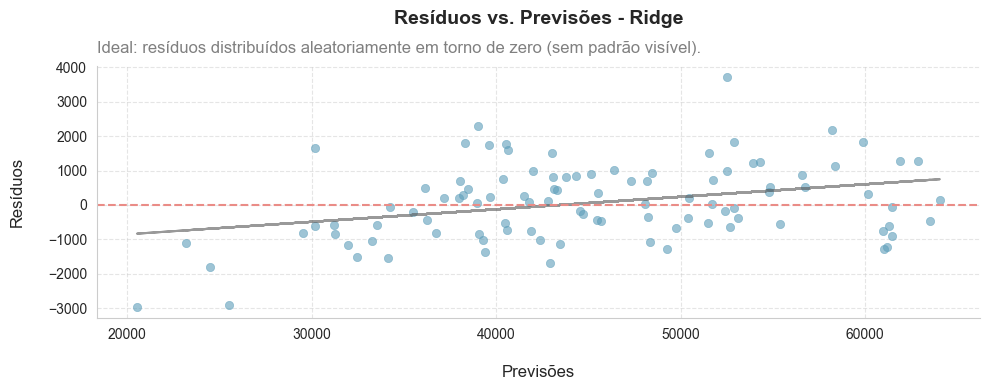

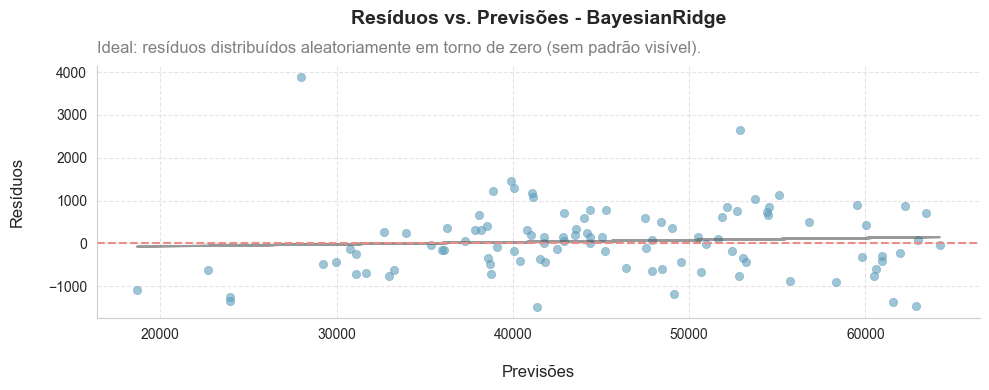

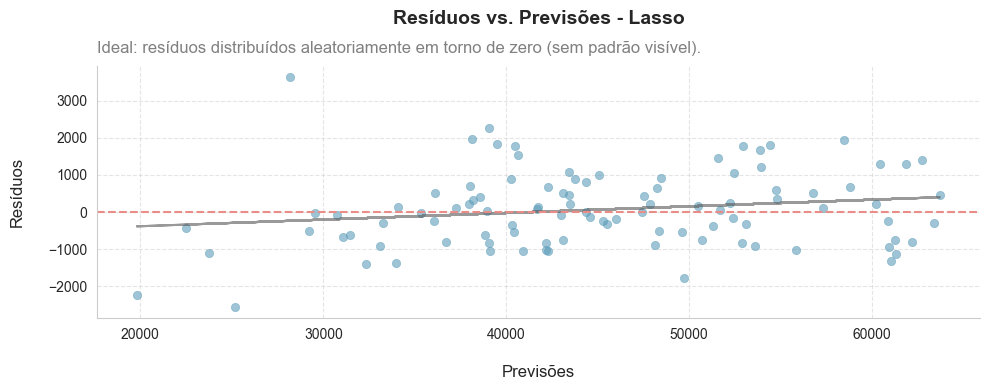

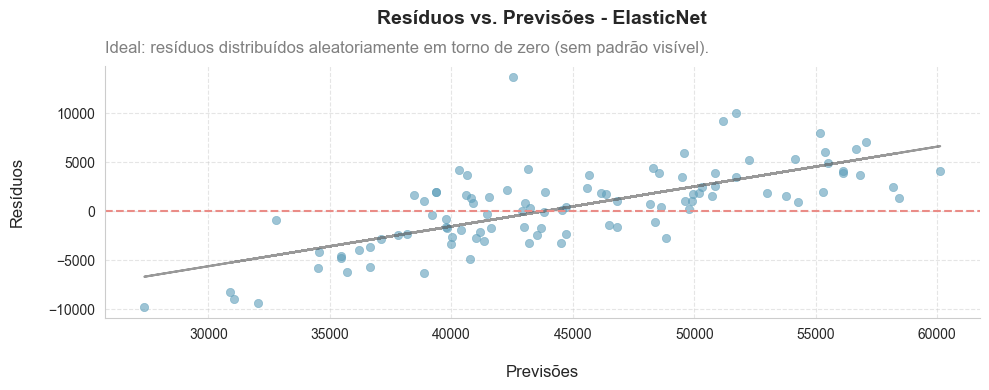

In [90]:
plot_residual_x_forecast(df_ranked_tuned, models, X_train, y_train, X_test, y_test, preprocessor)

## 5. Conclusões